# Сборный проект №1. Анализ продаж компьютерных игр

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.  
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Цель исследования: определить закономерности, определяющие успешность игры

Ход исследования:
1. Выгрузка данных;
2. Предобработка данных;
3. Исследование рынка компьютерных игр;
4. Поиск перспективных платформ;
5. Исследование популярности жанров;
6. Составление портретов пользователей по регионам;
7. Проверка гипотез;
8. Общий вывод и рекомендации.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

## Выгрзука данных

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Видно, что в данных присутствуют пропуски. 
Опишем столбцы и общую информацию о датасете: 
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Видно, что необходимо поменять тип данных в столбцах *Year_of_release* (с *float* на *int*), *user_score*, *Critic_score*. Также необходимо переименовать столбцы, чтобы привести их наименования к стандратному виду.  
Видим, что пропусков в данных достаточно много, визуализируем количество пропусков

In [5]:
(pd.DataFrame(round(data.isna().mean()*100,)).
sort_values(by=0, ascending=False).
rename(columns={0: 'Процент пропусков'}).
style.format("{:,.2f}%").
background_gradient('coolwarm').
set_properties(**{'text-align': 'center'}))

,Процент пропусков
Critic_Score,51.00%
User_Score,40.00%
Rating,40.00%
Year_of_Release,2.00%
Name,0.00%
Platform,0.00%
Genre,0.00%
NA_sales,0.00%
EU_sales,0.00%
JP_sales,0.00%


Больше половины пропусков содержится в столбце *Critic_score*, а также в столбцах *User_score* и *rating*. Совсем чуть-чуть по сравнению с лидерами по пропускам в столбце *Year_of_release*. Также есть минимальное количество пропусков в столбцах *Name* и *Genre*.

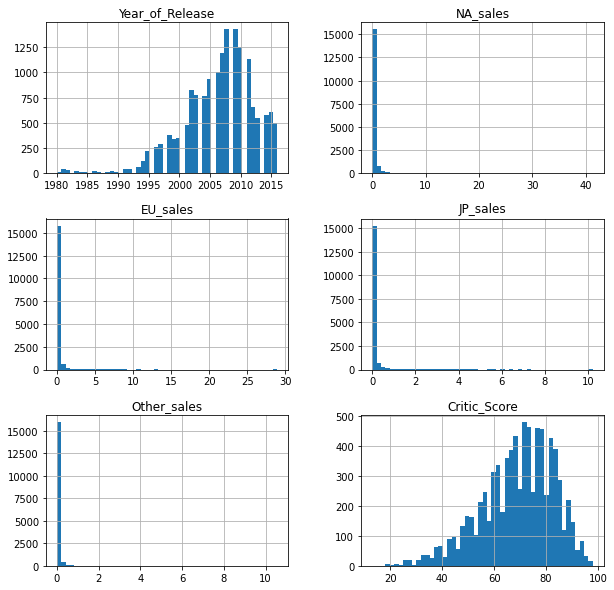

In [6]:
data.hist(figsize=(10,10), bins=50);

Анализ гистограмм дает следующие проблемы:
* Продажи большинства игр сосредоточены на небольшом промежутке однако есть игры с очень большими продажами, требуется дополнительное исследование;
* Большинство игр были выпущены с 2005 по 2010 год;
* Рейтинг критиков имеет явно выраженные пики, требуется дополнительный анализ.

**Вывод:** по итогам выгрузки и первичного анализа были выявлены проблемы: 
* Некорректный тип данных в некоторых столбцах (User_score, Critic_score, Year_of_release);
* В данных содержится большое количество пропусков;
* Большинство столбцов требуют переименования.

## Предобработка данных

### Переименования столбцов

Названия столбцов должны быть написаны в "змеином" стиле, то есть все слова с маленькой буквы и разделены нижними подчёркиваниями.

In [7]:
data.columns = data.columns.str.lower()

In [8]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Таким образом все столбцы сведены к единому стилю

### Преобразование данных к нужным типам

#### Год выпуска

Год выпуска должен быть очевидно целым числом. Однако в силу того, что в этом столбце содержится тип данных NaN, дефолтно выставляется тип данных с плавающей точкой. Преобразуем тип данных столбца в Int64, который поддерживает значения NaN.

In [9]:
data['year_of_release'] = data['year_of_release'].astype('Int64')

In [10]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Оценка критиков

Проблема аналогична проблеме в столбце с годом выпуска. Решение - то же

In [11]:
data['critic_score'] = data['critic_score'].astype('Int64')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   Int64  
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(2), float64(4), object(5)
memory usage: 1.4+ MB


#### Оценка пользователей

В этом столбце проблема с типом данных чуть отличается. Тип данных не float, а object, то есть нечисловые значения. Выведем уникальные значения в столбце.

In [13]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [14]:
data.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,<NA>,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,<NA>,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.0,0.07,73,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,<NA>,tbd,E


Видим, что кроме значения NaN в столбце есть 'tbd' (To Be Determined - требует уточнения). В датасете таких игр 2424. Такое значение используют, когда нет данных по оценке игры (сликшом мало отзывов). Возможно, такое значение появляется для малопопулярных игр или игр, пользователи которых не оставляют комментарии (например, инди-игры).
То есть эти значения можно заменить на NaN или на 0. Исследуем, сколько игр имеют рейтинг 0.

In [15]:
data.query('user_score == "0"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2835,My Little Pony: Pinkie Pie's Party,DS,2008,Adventure,0.66,0.0,0.0,0.06,<NA>,0,E


Всего одна игра имеет такой рейтинг. Тогда можно заменить пропуски и tbd на 0.

Исследуем, для каких игр появляются пропуски в значениях рейтинга игроков.

In [16]:
data[data['user_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,<NA>,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,<NA>,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,<NA>,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,<NA>,NaN,NaN


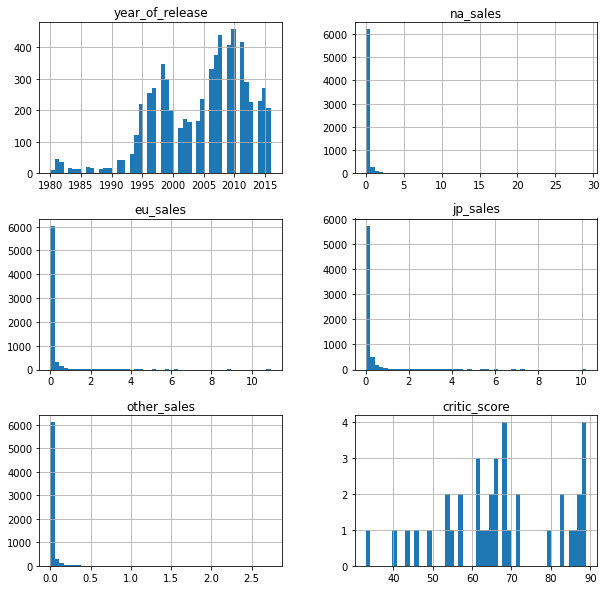

In [17]:
data[data['user_score'].isna()].hist(figsize=(10,10), bins=50);

In [18]:
data[data['user_score'].isna()].query('na_sales < 0.5')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
215,Monster Hunter Freedom 3,PSP,2010,Role-Playing,0.00,0.00,4.87,0.00,<NA>,NaN,NaN
244,Dragon Quest VII: Warriors of Eden,PS,2000,Role-Playing,0.20,0.14,4.10,0.02,<NA>,NaN,NaN
316,Dragon Warrior III,NES,1988,Role-Playing,0.10,0.00,3.77,0.00,<NA>,NaN,NaN
340,Friend Collection,DS,2009,Misc,0.00,0.00,3.67,0.00,<NA>,NaN,NaN
385,Monster Hunter 4,3DS,2013,Role-Playing,0.00,0.00,3.44,0.00,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,<NA>,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,<NA>,NaN,NaN


Оценок пользователей нет для игр, либо с очень низкими продажами, либо очень старые, но успешные. Для игр с низкими продажами причина отсутствия оценок в целом ясна - в них никто не играет. Возможно, старые игры не оценивают как нестареющую классику, чтобы не вводить их в современные рейтингы и не смешивать их с новыми играми. 

Таким образом, можно смело заменить NaN и tbd на 0. Для нас это будет знаком того, что игры с оценкой 0 не имеют её вовсе.

In [19]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = 0
data['user_score'].fillna(0, inplace=True)

Заполнение пропусков значениями позволяет более предсказуемо обрабатывать данные: например, мы точно будем знать, что пропуски в значениях заполнены именно 0. Также такое заполнение позволит более точечно выявить потенциально искажающие данные и выявить закономерности в образовании пропусков. Это в свою очередь позволит оптимизировать данные для анализа. Полагаю, что очищение данных от невалидных значений играет большую роль в машинном обучении.

Заменим тип данных на float

In [20]:
data['user_score'] = data['user_score'].astype('float')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   Int64  
 9   user_score       16715 non-null  float64
 10  rating           9949 non-null   object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.4+ MB


Теперь типы данных приведены в порядок

### Обработка пропусков

Пропуски остались в 5 столбцах: 
* *year_of_release*;
* *name*;
* *genre*;
* *critic_score*;
* *rating*.

#### Столбец name

Рассмотрим, в каких строках отсутствует название игры

In [22]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,<NA>,0.0,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,<NA>,0.0,NaN


Видим, что это и есть те два пропуска в столце с жанром игры. Эти записи целиком лишены смысла для анализа. Скорее всего, это дефект при выгрузке. Удалим их.

In [23]:
data = data.dropna(subset=['name']).reset_index(drop=True)

In [24]:
data.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score            0
rating             6764
dtype: int64

Записи с пропусками удалены. Двигаемся дальше.

#### Оценка критиков

In [25]:
data['critic_score'].unique()

<IntegerArray>
[  76, <NA>,   82,   80,   89,   58,   87,   91,   61,   97,   95,   77,   88,
   83,   94,   93,   85,   86,   98,   96,   90,   84,   73,   74,   78,   92,
   71,   72,   68,   62,   49,   67,   81,   66,   56,   79,   70,   59,   64,
   75,   60,   63,   69,   50,   25,   42,   44,   55,   48,   57,   29,   47,
   65,   54,   20,   53,   37,   38,   33,   52,   30,   32,   43,   45,   51,
   40,   46,   39,   34,   35,   41,   36,   28,   31,   27,   26,   19,   23,
   24,   21,   17,   22,   13]
Length: 83, dtype: Int64

Оценка представляет собой целой число, по всей видимости, от 0 до 100. Пропусков в данных очень много, примерно половина, поэтому заполнять медианой или средним нельзя. К тому же это будет не совсем правильно, так как мы пытаемся понять факторы успеха игры, а в этом случае мы немного скашиваем выборку.  
Скорее всего, пропуски возникли из-за того, что игры собрали слишком маленькую аудиторию и не были уостоены внимания критиков. Также, возможно, что игры слишком новые итоже не успели попасть под пристальный взор критиков.  
Есть два варианта: оставить как есть или заменить на некоторое уникальное значение, которое в исходной выборке не встречалось.
Так как м уже в оценках пользовательей заменили пропуски на 0, то здесь можно поступить аналогичным образом (к тому же в исходных данных 0 нет).

In [26]:
data['critic_score'].fillna(0, inplace=True)

In [27]:
data.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score            0
rating             6764
dtype: int64

#### Год выпуска

В этом случае процент пропусков не такой большой. Заменять любым значением ни в коем случае нельзя. Поэтому можно просто оставить так как есть.  
Пропуски с большей долей вероятности возникли из-за технической ошибки. Так, например, есть игры, в названии которых содержится год выпуска. Также, возможно, что игры были выпущены маленькими студиями и просто по ним не были заполнены надлежащим образом данные.

In [28]:
data[data['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,0,0.0,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16371,PDC World Championship Darts 2008,PSP,<NA>,Sports,0.01,0.00,0.00,0.00,43,0.0,E10+
16403,Freaky Flyers,GC,<NA>,Racing,0.01,0.00,0.00,0.00,69,6.5,T
16446,Inversion,PC,<NA>,Shooter,0.01,0.00,0.00,0.00,59,6.7,M
16456,Hakuouki: Shinsengumi Kitan,PS3,<NA>,Adventure,0.01,0.00,0.00,0.00,0,0.0,NaN


#### Рейтинг ESRB

Пропусков в данных достаточно много. Рассмотрим уникальные значения.

In [29]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Отметим сразу некоторые особенности. Данный рейтинг был введён с 1994 года. Логично предположить, что большинство игр без рейтинга были выпущены до 1994 года.

<AxesSubplot:>

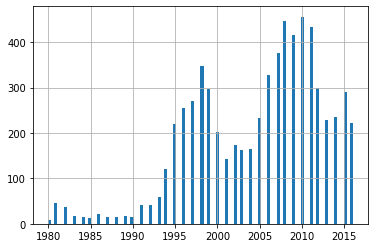

In [30]:
data[data['rating'].isna()]['year_of_release'].hist(bins=100)

Гипотеза не подтвердилась.  
Также стоит отметить, что ESRB распространена в Канаде и США, для Европы более характерна система PEGI, а для Японии CERO. Возможно, игры без этого рейтинга не ориентированы на американские площадки.  
Заметим также, что присутсвует значение рейтинга RP (rating pending) - ожидание рейтинга, это свойствено для игр в стадии демонстрационного доступа. Проверим это.

In [31]:
data[data['rating'] == 'RP']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13671,Clockwork Empires,PC,<NA>,Strategy,0.0,0.04,0.0,0.00,58,3.8,RP
14268,Supreme Ruler: Cold War,PC,2011,Strategy,0.0,0.03,0.0,0.01,63,6.8,RP
16178,WRC: FIA World Rally Championship,PC,<NA>,Racing,0.0,0.01,0.0,0.00,65,0.0,RP


Таких игр всего три, но все они вряд ли подходят под определение. Скорее всего, издатель или платформа просто забыла обновить данные об игре.

Также отметим, что рейтинг E был введён в 1998, в то время как рейтинг K-A действовал только до 1998 года. Проверим это

In [32]:
data[data['rating'] == 'K-A']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
656,Theme Hospital,PC,1997,Strategy,2.30,0.10,0.00,0.00,0,9.0,K-A
902,PaRappa The Rapper,PS,1996,Misc,0.26,0.16,1.46,0.03,92,7.4,K-A
16679,Worms 2,PC,1997,Strategy,0.00,0.01,0.00,0.00,0,8.1,K-A


<AxesSubplot:>

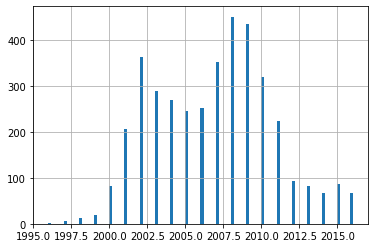

In [33]:
data[data['rating'] == 'E']['year_of_release'].hist(bins=100)

Есть небольшие выбросы до 1998 года, но, скорее всего, оценка игр производилась позже даты выхода.

Пропуски можно заменить значением RP как наиболее подходящим по смыслу.

In [34]:
data['rating'].fillna('RP', inplace=True)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  Int64  
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.4+ MB


Пропуски обработаны

### Работа с дубликатами

Рассмотрим данные на наличие явных дубликатов.

In [36]:
data.duplicated().sum()

0

Явных дубликатов нет. Тогда рассмотрим дубликаты в названиях игр, как наиболее очевидный вариант дублирования

In [37]:
data[data['name'].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83,4.8,M
37,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,5.54,5.73,0.49,1.57,88,3.2,M
41,Call of Duty: Black Ops,PS3,2010,Shooter,5.99,4.37,0.48,1.79,88,6.4,M
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M
...,...,...,...,...,...,...,...,...,...,...,...
16704,Men in Black II: Alien Escape,GC,2003,Shooter,0.01,0.00,0.00,0.00,0,0.0,T
16707,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,0,0.0,RP
16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,0,0.0,RP
16711,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,0,0.0,RP


In [38]:
data[data['name'] == 'Call of Duty: Black Ops II']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83,5.3,M
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83,4.8,M
1226,Call of Duty: Black Ops II,PC,2012,Shooter,0.64,0.69,0.00,0.19,74,4.2,M
4705,Call of Duty: Black Ops II,WiiU,2012,Shooter,0.20,0.18,0.00,0.03,81,6.9,M


Игры с одним и тем же названием есть на разных платформах, что логично. Будем считать, что неявных дубликатов в данных тоже нет.

In [39]:
(data.applymap(lambda x: str(x).lower()).
 duplicated(subset=['name', 'platform', 'year_of_release']).
 sum())

1

Остался один неполный дубликат. Посмотрим, что это за строки

In [40]:
(data[data.applymap(lambda x: str(x).lower())
      .duplicated(subset=['name', 'platform', 'year_of_release'], 
                  keep=False)])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83,5.5,E
16228,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83,5.5,E


Видно, что последняя запись является явной аномалией, скорее всего, это просто ошибка при выгрузке данных. Избавимся от него.

In [41]:
data = (data.drop(data[data.applymap(lambda x: str(x).lower())  #приводим значения к нижнему регистру
               .duplicated(subset=['name', 'platform', 'year_of_release'], keep='first')]. #находим строку с дубликатом
          index.values). #получаем её индекс
reset_index(drop=True)) #обноваляем индексацию в датафрейме

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16712 entries, 0 to 16711
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     16712 non-null  Int64  
 9   user_score       16712 non-null  float64
 10  rating           16712 non-null  object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.4+ MB


In [43]:
data.applymap(lambda x: str(x).lower()).duplicated(subset=['name', 'platform', 'year_of_release']).sum()

0

Неявные и неполные дубликаты удалены.

### Добавить столбец с общим объёмом продаж

In [44]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [45]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,RP,31.38


**Вывод:**
1. Были переимнованы столбцы (названия переведены в нижний регистр);
2. Была проведена работа с измененим типа данных столбцов. Заменён тип данных в столбцах year_of_release (с float на int64), critic_score (с float на int64) и user_score (c object на float);
3. Была проведена работа с пропусками. Была произведена замена в столбцах rating (на значение RP), user_score, critic_score (на 0). Строки с пропусками в name и genre были удалены. Пропуски были оставлены в столбце year_of_release.
4. Был добавлен столбец суммарных продаж.



## Исследовательский анализ данных

### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [46]:
data.groupby('year_of_release')['name'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     652
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

Text(0.5, 1.0, 'Продажи игр по годам')

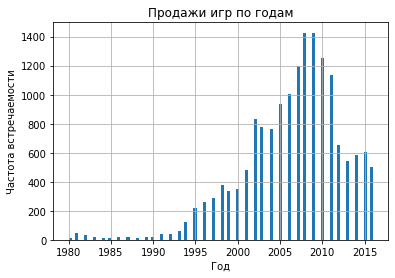

In [47]:
data['year_of_release'].hist(bins=100);
plt.xlabel('Год')
plt.ylabel('Частота встречаемости')
plt.title('Продажи игр по годам')

Видна тенденция к увеличению числа компьютерных игр. В 80-ые годы прошлого века произошёл кризис компьютерных игр из-за переполнения рынка однотипными играми, когда разорилось множество компаний, к тому же рынок был не так развит как сейчас. В ту эпоху успешные игры были скорее редкостью. В 90ые годы произошёл переход от двухмерной графики к трёхмерной, что поспособствовало росту рынка, также сыграло роль развитие компьютерных сетей и появление многопользовательского режима.  
В двухтысячные годы продолжалось совершенствование трёхмерной графики игр, приближающей отдельные игры к кинофильмам, и распространение сетевых игр. Произошёл бум казуальных игр, ориентированных на самую широкую аудиторию — этому способствовало распространение доступа к Интернету и расцвет социальных сетей; популярность приобрели системы цифровой дистрибуции игр, как Steam. После 2012 года виден резкий спад обусловленный экономическим кризисом и возросшими требованиями со стороны пользваотелей: теперь игры могут разрабатываться по много лет (нормальными цифрами могут являться 10-15 лет)

Все исторические тенденции ярко прослеживаются на диаграмме.

Как бы не было интересно заниматься ретроспективным анализом, нас всё же интересуют данные для прогнозирования. Как итог, все данные нас явно не интересуют, так как развивались они под воздействием модных на тот момент тендцений: **для рассмотрения наиболее важный период с 1995 года, когда началось более широкое развитие рынка компьютерных игр**.

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [48]:
pivot_table_platforms = pd.pivot_table(data=data, 
                                       index='platform', 
                                       values='total_sales', 
                                       aggfunc='sum')
pivot_table_platforms.columns = ['sum_sales']
pivot_table_platforms.sort_values(by='sum_sales', ascending=False)

,sum_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.64
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


In [49]:
#создаём сводную таблицу по платформам и годам
pivot_table_platforms_by_years = pd.pivot_table(data=data, 
                                                index=['platform', 'year_of_release'], 
                                                values='total_sales', 
                                                aggfunc='sum')
#сбрасываем индекс для построения графиков
pivot_table_platforms_by_years = pivot_table_platforms_by_years.reset_index()
#создаём список с уникальными наименованиями платформ
platforms = pivot_table_platforms_by_years['platform'].unique()

In [50]:
pivot_table_platforms_by_years.head(20)

,platform,year_of_release,total_sales
0,2600,1980,11.38
1,2600,1981,35.68
2,2600,1982,28.88
3,2600,1983,5.84
4,2600,1984,0.27
5,2600,1985,0.45
6,2600,1986,0.67
7,2600,1987,1.94
8,2600,1988,0.74
9,2600,1989,0.63


Исходя из отображенных результатов, можно предположить, что платформы начинают с очень высоких продаж, достигают пика через **3-5 года**, а затем постепенно сходят на нет. Исследуем среднее время жизни платформ.

In [51]:
len(platforms)

31

В датасете присутствует 31 платформа. Это достаточно много исследуем только самые крупные. Судя по сводной таблице самыми крупными игроками являются PS2, X360, PS3, Wii, DS, PS. Следующая платформа по продажам отличается почти в два раза, а это уже существенная разница

In [52]:
platforms_top = pivot_table_platforms.reset_index().query('sum_sales > 700')['platform'].unique()

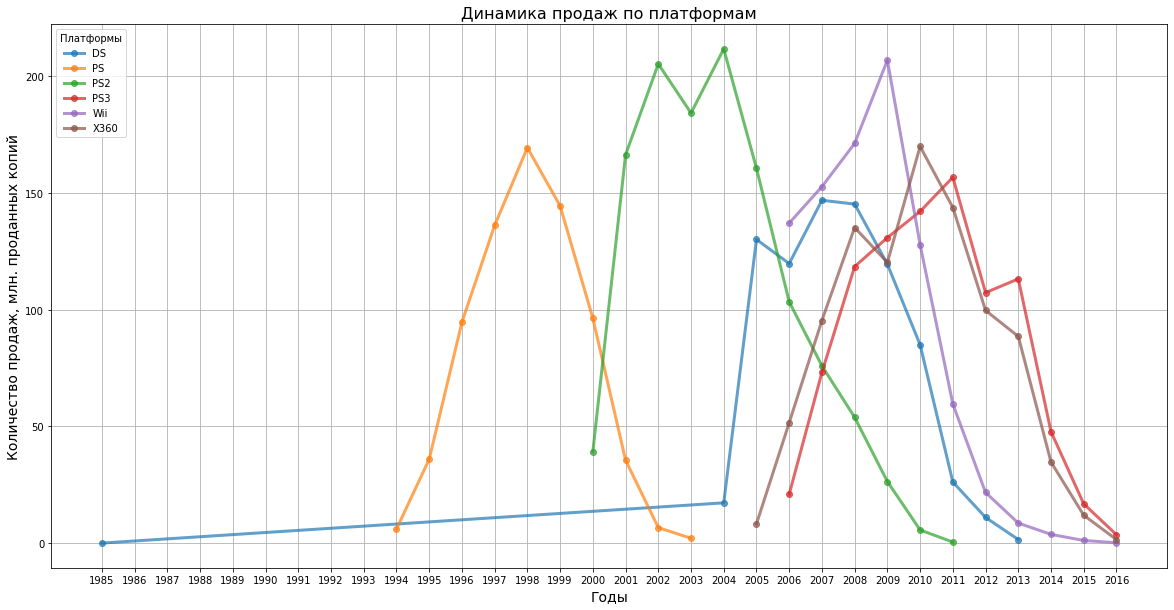

In [53]:
fig = plt.figure(figsize=(20, 10))
for platform in platforms_top:
    # Отфильтровываем данные по конкретной платформе
    data_for_platform = pivot_table_platforms_by_years.query(f'platform == "{platform}"')
    plt.plot(data_for_platform['year_of_release'], 
             data_for_platform['total_sales'], 
             marker='o', 
             label=platform, 
             linewidth=3, 
             alpha=0.7)
# Добавляем заголовок и подписи осей
plt.title('Динамика продаж по платформам', fontsize=16)
plt.xlabel("Годы", fontsize=14)
plt.ylabel("Количество продаж, млн. проданных копий", fontsize=14)
plt.legend(title="Платформы", loc="upper left")
plt.xticks([i for i in range(1985, 2017, 1)])
plt.grid(True)
plt.show()


 <div class="alert alert-dang er">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Странный выброс 1985 года у DS, можно посмотреть когда платформу выпустили на рынок, стоит удалить аномалию  

Платформа Nintendo DS была выпущена в 2004 году. По всей видимости, данные за 1985 год - это ошибка. От них стоит избавиться.

In [54]:
data.query('(platform == "DS" and year_of_release < 2004)')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15955,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,0,0.0,RP,0.02


Всего одна запись выбивается из общей картины. По всей видимости, при заполнении данных ошибочно обратили внимание на DS в названии игры

In [55]:
data = data.query('~(platform == "DS" and year_of_release < 2004) or (year_of_release.isna())').reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16711 entries, 0 to 16710
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16711 non-null  object 
 1   platform         16711 non-null  object 
 2   year_of_release  16442 non-null  Int64  
 3   genre            16711 non-null  object 
 4   na_sales         16711 non-null  float64
 5   eu_sales         16711 non-null  float64
 6   jp_sales         16711 non-null  float64
 7   other_sales      16711 non-null  float64
 8   critic_score     16711 non-null  Int64  
 9   user_score       16711 non-null  float64
 10  rating           16711 non-null  object 
 11  total_sales      16711 non-null  float64
dtypes: Int64(2), float64(6), object(4)
memory usage: 1.6+ MB


Стало на один меньше, что и предполагалось. Перестроим график

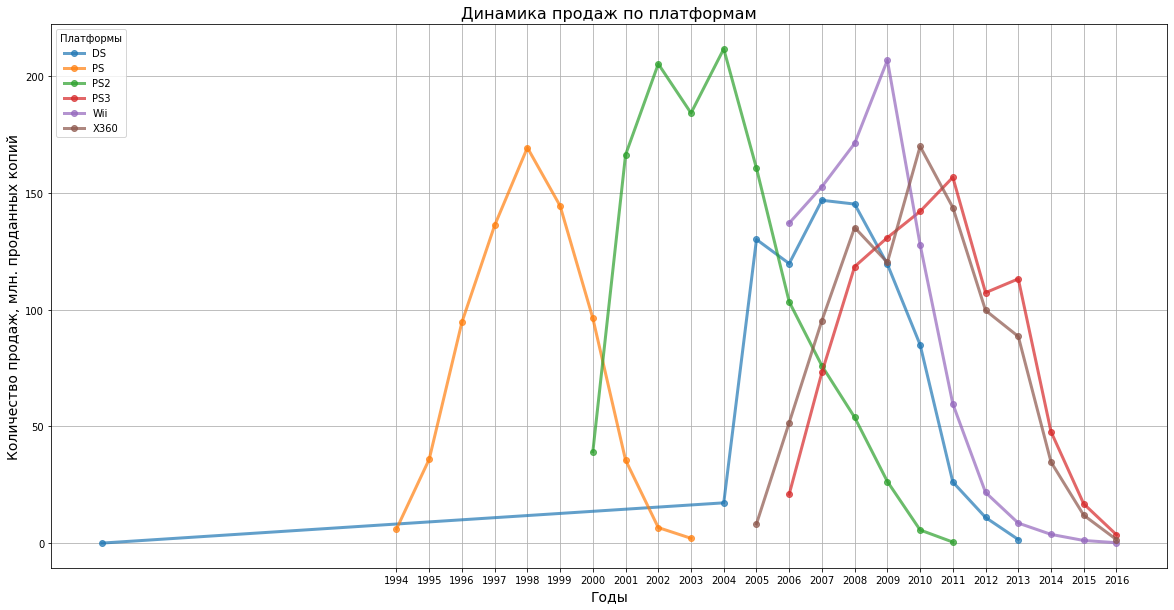

In [56]:
fig = plt.figure(figsize=(20, 10))
for platform in platforms_top:
    # Отфильтровываем данные по конкретной платформе
    data_for_platform = pivot_table_platforms_by_years.query(f'platform == "{platform}"')
    plt.plot(data_for_platform['year_of_release'], 
             data_for_platform['total_sales'], 
             marker='o', 
             label=platform, 
             linewidth=3, 
             alpha=0.7)
# Добавляем заголовок и подписи осей
plt.title('Динамика продаж по платформам', fontsize=16)
plt.xlabel("Годы", fontsize=14)
plt.ylabel("Количество продаж, млн. проданных копий", fontsize=14)
plt.legend(title="Платформы", loc="upper left")
plt.xticks([i for i in range(1994, 2017, 1)])
plt.grid(True)
plt.show()

In [57]:
# check
pivot_table_platforms_by_years[pivot_table_platforms_by_years.platform == 'DS'][:2]

,platform,year_of_release,total_sales
25,DS,1985,0.02
26,DS,2004,17.27


Самые крупные игроки на рынке имели следующий путь: 
* PS2 c 2000 по 2011 (12 лет)
* X360 с 2005 по 2016 (12 лет)
* PS3 с 2006 по 2016 (11 лет)
* Wii с 2006 по 2016 (11 лет)
* DS с 2004 по 2013 (10 лет)
* PS с 1994 по 2003 (10 лет)

**То есть в среднем жизнь платформы составляет примерно 12 лет (от 10 до 12 лет). Действительно, платформы устаревают, появляются новые технологии и необходимы достаточно серьёзные изменения, чтобы идти в ногу со временем.**

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Актуальный период можно определить в 4 года, то есть компании, появившееся 3-4 года назад достигают своего пика, а наиболее популярные 3-4 года назад платформы сходят уже должны выйти с рынка. также должны появиться новые перспективные платформы. **Поэтому актуальный период можно взять с 2014 по 2016 года.**

In [58]:
data_actual = data.query('year_of_release >= 2014')

In [59]:
data_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16710
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   Int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     1689 non-null   Int64  
 9   user_score       1689 non-null   float64
 10  rating           1689 non-null   object 
 11  total_sales      1689 non-null   float64
dtypes: Int64(2), float64(6), object(4)
memory usage: 174.8+ KB


Данные выгружены, теперь для анализа осталось 1689 записи.

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [60]:
#создаём сводную таблицу по платформам и годам
pivot_table_actual_platforms = pd.pivot_table(data=data_actual, 
                                              index=['platform', 'year_of_release'], 
                                              values='total_sales', 
                                              aggfunc='sum')
pivot_table_actual_platforms

total_sales
platform year_of_release             
3DS      2014                   43.76
         2015                   27.78
         2016                   15.14
PC       2014                   13.28
         2015                    8.52
         2016                    5.25
PS3      2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2014                    0.24
         2015                    0.12
PSV      2014                   11.90
         2015                    6.25
         2016                    4.25
Wii      2014                    3.75
         2015                    1.14
         2016                    0.18
WiiU     2014                   22.03
         2015                   16.35
         2016                    4.60
X360     2014                   34.74
         2015                   11.96
         2016                    1.52
XOne     2014                   54.07
         2015                   60.14
         2016                   26.15

Выделим сомнительные варианты варианты: 3DS, PSP, X360, Wii, PSV, WiiU, X360. Если сравнить 2014 и 2015 года, их продажи снизились, а PSP в принципе не имеет продаж за неполный 2016 год. Очевидно подходящие - PS4 и XOne.

In [61]:
#сбрасываем индекс для построения графиков
pivot_table_actual_platforms = pivot_table_actual_platforms.reset_index()
#создаём список с уникальными наименованиями платформ
platforms_actual = pivot_table_actual_platforms['platform'].unique()

In [62]:
len(platforms_actual)

10

В рассмотрении осталось всего 10 платформ. Выбор невелик,, но всё же есть.

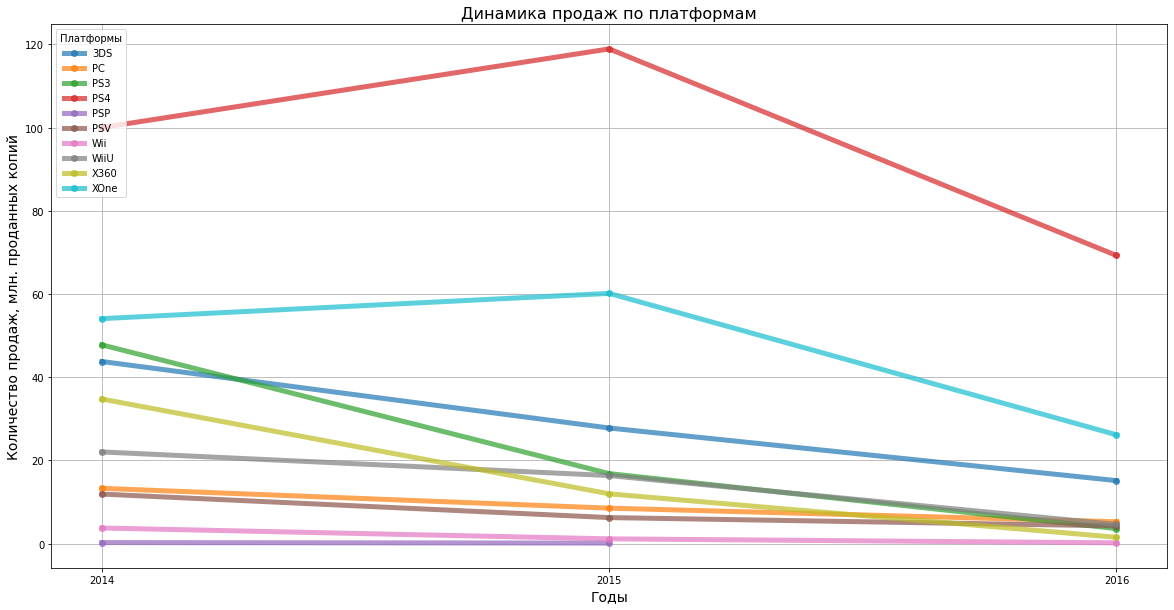

In [63]:
fig = plt.figure(figsize=(20, 10))
for platform in platforms_actual:
    # Отфильтровываем данные по конкретной платформе
    data_for_platform = pivot_table_actual_platforms.query(f'platform == "{platform}"')
    plt.plot(data_for_platform['year_of_release'], data_for_platform['total_sales'], marker='o', label=platform, linewidth=5, alpha=0.7)
# Добавляем заголовок и подписи осей
plt.title('Динамика продаж по платформам', fontsize=16)
plt.xlabel("Годы", fontsize=14)
plt.ylabel("Количество продаж, млн. проданных копий", fontsize=14)
plt.legend(title="Платформы", loc="upper left")
plt.xticks([i for i in range(2014, 2017, 1)])
plt.grid(True)
plt.show()


Видны следующие закономерности:
* PSV, Wii, WiiU, PSP находятся на стабильно низком уровне;
* PS3 и X360 уже менее перспективны в силу того, что появились приставки того же производителя, но уже нового поколения (PS4 и XOne);
* 3DS постепенно идёт на спад, но продажи всё ещё не такие уж и маленькие по сравнению с остальными платформами, поэтому можно отнести её к перспективным платформам;
* PC (персональный комьютер) остаётся стабильным многие годы подряд, поэтому его тоже можно отнести к перспективным.

**Наиболее перспективными видятся плафтормы XOne и PS4, которые будут популярны ещё несколько лет (2017 год точно). Также в этот список можно добавить PC и 3DS**

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Стоит дополнить перечень перспективных платформ

        
даже  на падающих продажах можно заработать, когда объем составляет около 15-20 млн. копий, как например с 3DS
        
30-тилетняя история персональных компьютеров говорит, что игры для PC можно включить в рекомендацию
        


### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

Рассмотрм суммарные продажи по плафтормам за актуальный период.

In [64]:
pd.pivot_table(data=data_actual, index=['platform'], values='total_sales', aggfunc='sum')


,total_sales
platform,
3DS,86.68
PC,27.05
PS3,68.18
PS4,288.15
PSP,0.36
PSV,22.40
Wii,5.07
WiiU,42.98
X360,48.22


Построим "ящики с усами" для продаж на каждой платформе.

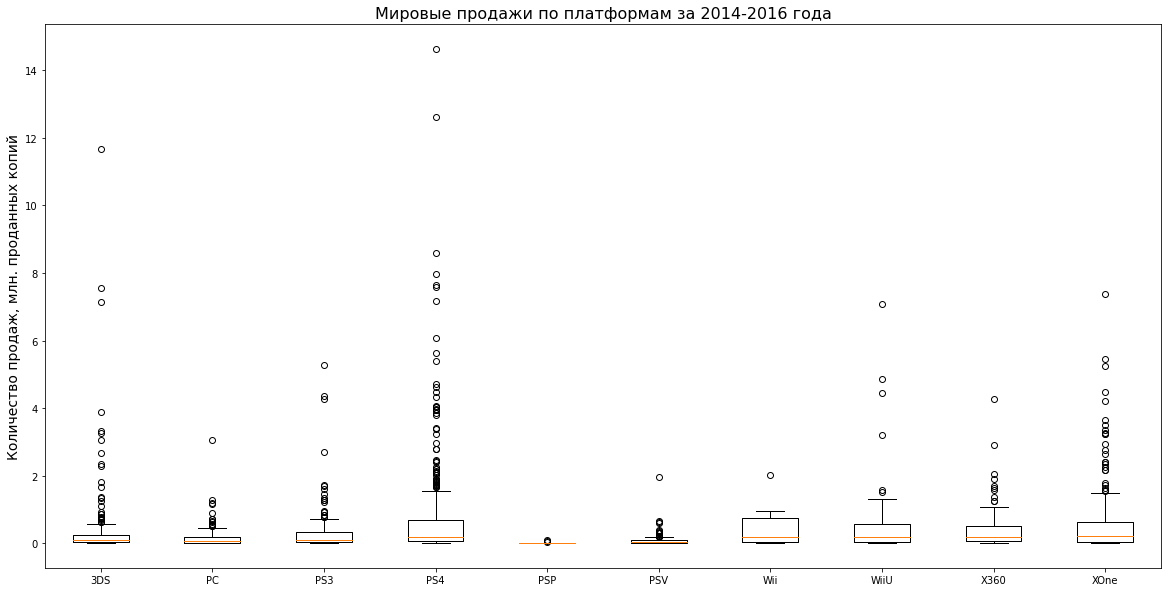

In [65]:
fig = plt.figure(figsize=(20, 10))
box_data = []
labels_for_plots = []
for platform in platforms_actual:
    # Отфильтровываем данные по конкретной платформе и убираем DS из рассмотрения
    if platform != 'DS':
        box_data.append(data_actual.query(f'platform == "{platform}"')['total_sales'])
        labels_for_plots.append(platform)
# Добавляем заголовок и подписи осей
plt.boxplot(box_data, 
            labels=labels_for_plots)
plt.title('Мировые продажи по платформам за 2014-2016 года', fontsize=16)
plt.ylabel("Количество продаж, млн. проданных копий", fontsize=14)
plt.show()

Рассмотрим детальнее график и отсортируем по медиане.

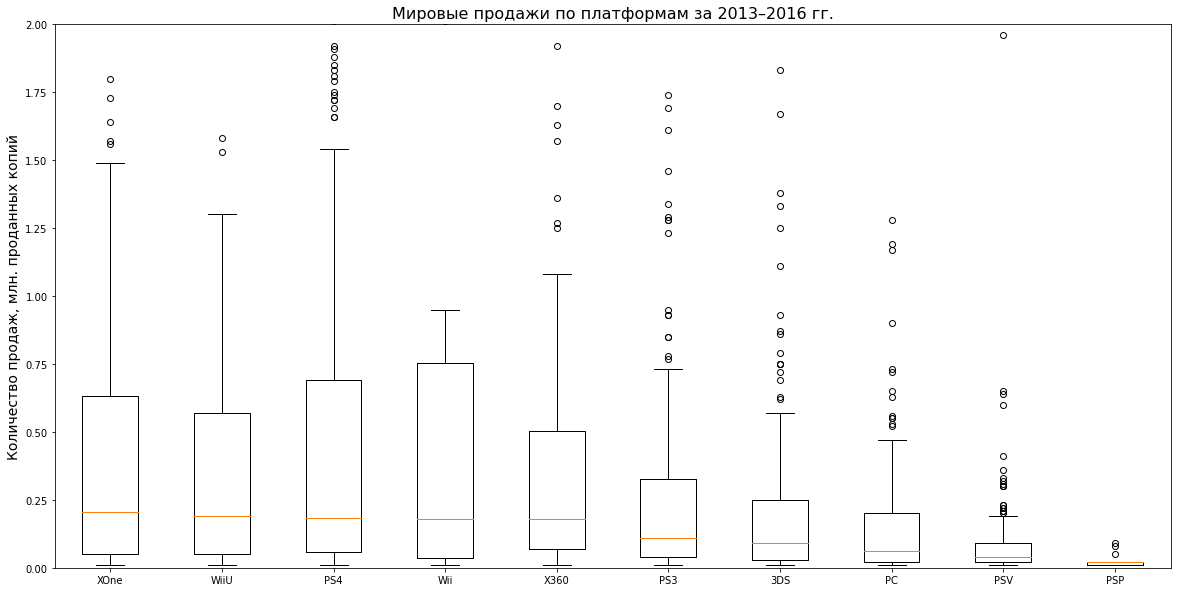

In [66]:
fig = plt.figure(figsize=(20, 10))
box_data = []
labels_for_plots = []

for platform in platforms_actual:
    sales_group = data_actual.query(f'platform == "{platform}"')['total_sales']
    box_data.append(sales_group.reset_index(drop=True))  # Сбросить индексы
    labels_for_plots.append(platform)

medians = [group.median() for group in box_data]

# Сортировка по медиане
sorted_data = sorted(zip(medians, box_data, 
                         labels_for_plots), 
                     key=lambda x: x[0], 
                     reverse=True) #объединяем объекты и сортируем по медиане
sorted_groups = [x[1] for x in sorted_data]
sorted_labels = [x[2] for x in sorted_data]

plt.boxplot(sorted_groups, labels=sorted_labels)
plt.title('Мировые продажи по платформам за 2013–2016 гг.', fontsize=16)
plt.ylabel("Количество продаж, млн. проданных копий", fontsize=14)
plt.ylim(0, 2)
plt.show()

Видно, что разные платформы обладают разной картиной на диаграмме. Например, небольшие платформы как PSP и PSV имеют совсем небольшие ящики и усы. У крупных платформ (Wii, PS4, WiiU, X360, XOne, PS3) медиана находится примерно на одном уровне 0.2 миллиона проданных копий.
Самый большой аномальный выброс среди всех платформ и продаж у PS3 - около 22 млн. проданных копий. Основная часть аномалий собирается до 10 млн. копий.

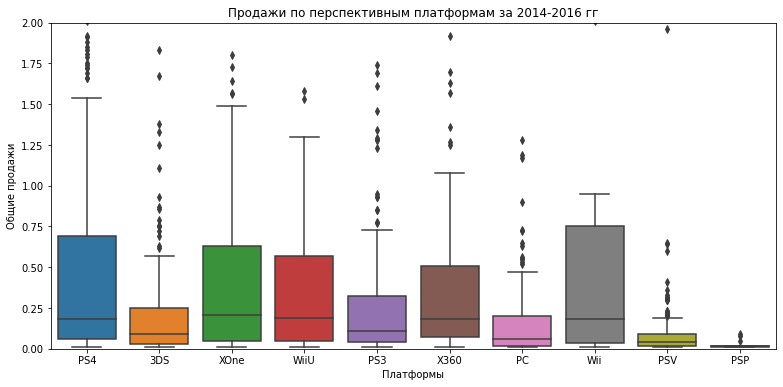

In [67]:
# код от ревьюера 
import seaborn as sns

plt.figure(figsize=(13, 6))
(
    sns.boxplot(data = data_actual, y = 'total_sales', x='platform')
        .set(title = 'Продажи по перспективным платформам за 2014-2016 гг', xlabel = 'Платформы', 
                             ylabel = 'Общие продажи', ylim=(0,2))
);

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Рассмотрим наиболее популярную и перспективную плафторму - PS4. Эти данные будут наиболее полезны при дальнейшем анализе. Также избавимся от нулевых значений, которыми мы заменили пропущенные значения.

In [68]:
data_actual_PS4 = data_actual.query('platform == "PS4" and ~(user_score == 0 and critic_score == 0)')

In [69]:
# check
data_actual_PS4.sort_values('user_score').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15019,Assault Suit Leynos,PS4,2016,Shooter,0.02,0.00,0.00,0.00,67,0.0,E10+,0.02
14292,Just Dance 2017,PS4,2016,Misc,0.02,0.00,0.00,0.01,73,0.0,E10+,0.03
8241,MotoGP 15,PS4,2015,Racing,0.00,0.12,0.03,0.02,66,0.0,RP,0.17
7478,Tony Hawk's Pro Skater 5,PS4,2015,Sports,0.09,0.08,0.00,0.03,32,1.5,T,0.20
12755,Rugby World Cup 2015,PS4,2015,Sports,0.00,0.05,0.00,0.01,25,1.9,E,0.06


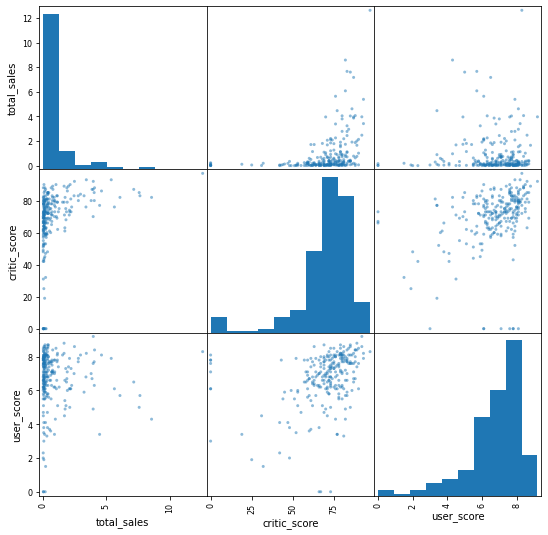

In [70]:
pd.plotting.scatter_matrix(data_actual_PS4[['total_sales', 'critic_score', 'user_score']], figsize=(9, 9));

In [71]:
data_actual_PS4[['total_sales', 'critic_score', 'user_score']].corr().round(3)

,total_sales,critic_score,user_score
total_sales,1.000,0.341,-0.008
critic_score,0.341,1.000,0.335
user_score,-0.008,0.335,1.000


По диаграммам видна явная связь между оценкой критиков и оценкой пользователей (коэффициент корреляции 0,335). 

Можно выявить слабую взаимосвязь между общими продажами и оценкой критиков: чем выше оценка, тем выше продажи (коэффициент корреляции 0,341). Возможно, это связано с тем, что пользователи изначально ориентируются на оценки критиков при покупке новой игры. После основной волны продаж, вызванных ажиотажным спросом, оставляют свои оценки и пользователи. Они уже влияют на волну покупок после основного периода продаж, из-за чего у них почти нет влияния на продажи.

### Соотнесите выводы с продажами игр на других платформах.

Рассмотрим другие платформы. Например, X360

In [72]:
data_actual_X360 = data_actual.query('platform == "X360" and ~(user_score == 0 and critic_score == 0)')

In [73]:
data_actual_X360

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
263,Call of Duty: Advanced Warfare,X360,2014,Shooter,2.77,1.11,0.0,0.40,0,4.9,M,4.28
494,FIFA 15,X360,2014,Sports,0.79,1.92,0.0,0.21,0,4.2,E,2.92
828,Madden NFL 15,X360,2014,Sports,1.77,0.06,0.0,0.22,0,5.5,E,2.05
897,Destiny,X360,2014,Shooter,1.31,0.43,0.0,0.18,0,4.7,T,1.92
1129,NBA 2K15,X360,2014,Sports,1.35,0.11,0.0,0.17,0,3.0,E,1.63
...,...,...,...,...,...,...,...,...,...,...,...,...
14418,Rugby World Cup 2015,X360,2015,Sports,0.00,0.03,0.0,0.00,0,8.0,E,0.03
14765,Cabela's Big Game Hunter: Pro Hunts,X360,2014,Shooter,0.02,0.00,0.0,0.00,0,7.3,T,0.02
15116,Rugby League Live 3,X360,2015,Action,0.00,0.02,0.0,0.00,0,7.0,E,0.02
15374,Back to the Future: The Game,X360,2015,Adventure,0.02,0.00,0.0,0.00,0,7.5,RP,0.02


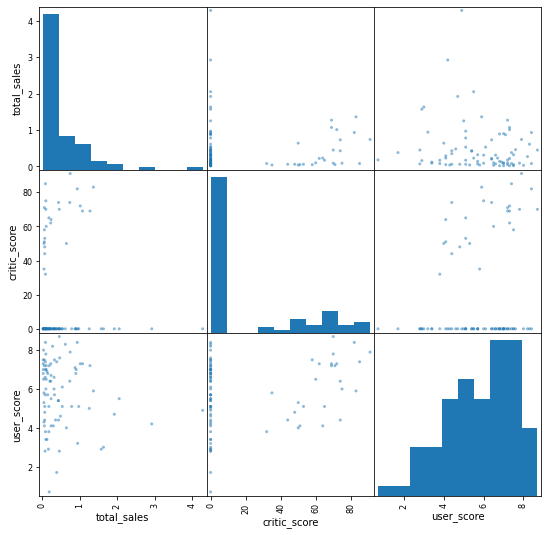

In [74]:
pd.plotting.scatter_matrix(data_actual_X360[['total_sales', 'critic_score', 'user_score']], figsize=(9, 9));

In [75]:
data_actual_X360[['total_sales', 'critic_score', 'user_score']].corr().round(3)

,total_sales,critic_score,user_score
total_sales,1.000,-0.050,-0.138
critic_score,-0.050,1.000,0.224
user_score,-0.138,0.224,1.000


Матрица корреляции имеет немного другой вид. Теперь из-за большого количества 0 в оценке критиков корреляционный коэффициент примерно равен 0, то есть нет корреляции между количеством продаж и оценкой критиков.  
Для проверки стоит рассмотреть ещё платформы, а также попробовать очистить нулевые значения.

In [76]:
data_actual_X360_cleaned = data_actual.query('platform == "X360" and ~(user_score == 0 or critic_score == 0)')

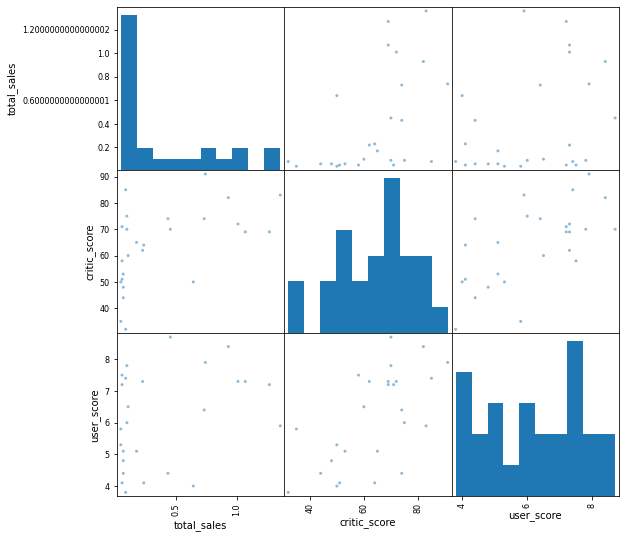

In [77]:
pd.plotting.scatter_matrix(data_actual_X360_cleaned[['total_sales', 'critic_score', 'user_score']], figsize=(9, 9));

In [78]:
data_actual_X360_cleaned[['total_sales', 'critic_score', 'user_score']].corr().round(3)

,total_sales,critic_score,user_score
total_sales,1.000,0.526,0.337
critic_score,0.526,1.000,0.625
user_score,0.337,0.625,1.000


Очистка данных повысила корреляционный коэффициент и привела к результатам схожим с PS4.

Рассмотрим игры на персональный компьютер.

In [79]:
data_actual_PC = data_actual.query('platform == "PC" and ~(user_score == 0 and critic_score == 0)')

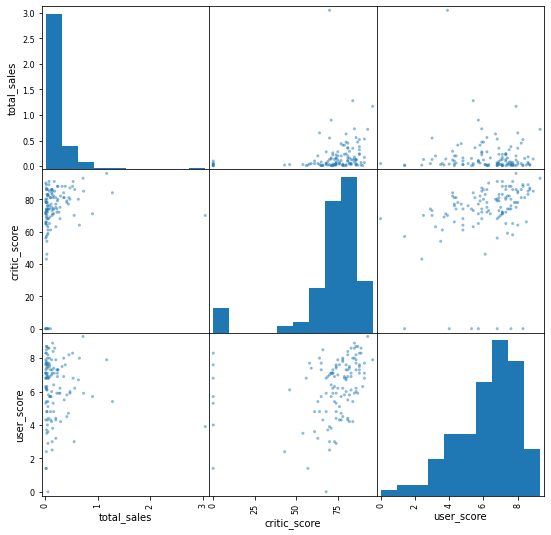

In [80]:
pd.plotting.scatter_matrix(data_actual_PC[['total_sales', 'critic_score', 'user_score']], figsize=(9, 9));

In [81]:
data_actual_PC[['total_sales', 'critic_score', 'user_score']].corr().round(3)

,total_sales,critic_score,user_score
total_sales,1.000,0.181,-0.056
critic_score,0.181,1.000,0.289
user_score,-0.056,0.289,1.000


Корреляция есть, но она слабже. 
Однако стоит учитывать, что региональные платформы, например, Wii, будут иметь свою специфику. В силу того, что в Азии будут использовать другие сервисы с оценками от критиков и пользователей. На имеющихся данных проверить эти гипотезы нельзя.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [82]:
pivot_table_genres = pd.pivot_table(data=data_actual, 
                                    index='genre', 
                                    values=['total_sales', 'na_sales', 'eu_sales', 'jp_sales'], 
                                    aggfunc=['sum'])
pivot_table_genres.columns = ['eu_sales_sum', 'jp_sales_sum', 'na_sales_sum', 'total_sales_sum']
pivot_table_genres.sort_values(by='total_sales_sum', ascending=False)

,eu_sales_sum,jp_sales_sum,na_sales_sum,total_sales_sum
genre,,,,
Action,74.68,29.58,72.53,199.36
Shooter,65.52,4.87,79.02,170.94
Sports,45.73,3.26,46.13,109.48
Role-Playing,28.17,31.16,33.47,101.44
Misc,12.86,5.61,15.05,37.55
Fighting,6.69,6.37,12.43,28.22
Racing,14.13,1.76,8.74,27.52
Platform,6.80,2.69,6.79,18.09
Adventure,6.49,3.60,5.64,17.55


In [83]:
genres_actual = pivot_table_genres.index.values
genres_actual

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

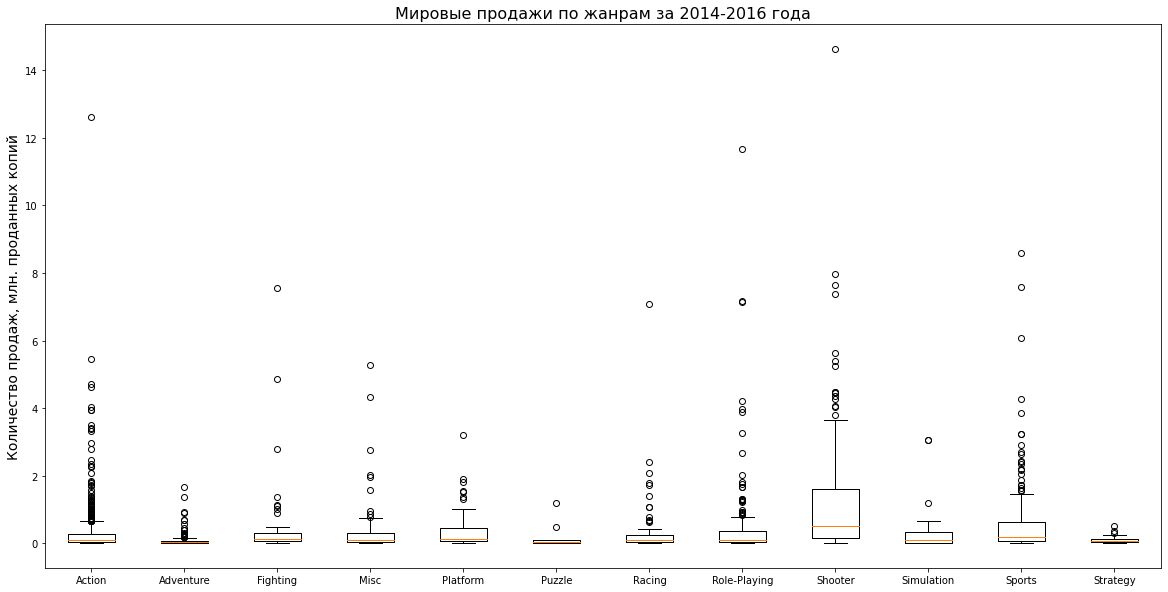

In [84]:
fig = plt.figure(figsize=(20, 10))
box_data = []
labels_for_plots_genres = []
for genre in genres_actual:
    # Отфильтровываем данные по конкретному жанру
    box_data.append(data_actual.query(f'genre == "{genre}"')['total_sales'])
    labels_for_plots_genres.append(genre)
# Добавляем заголовок и подписи осей
plt.boxplot(box_data, 
            labels=labels_for_plots_genres)
plt.title('Мировые продажи по жанрам за 2014-2016 года', fontsize=16)
plt.ylabel("Количество продаж, млн. проданных копий", fontsize=14)
plt.show()

Рассмотрим подробнее и отсортируем по медиане

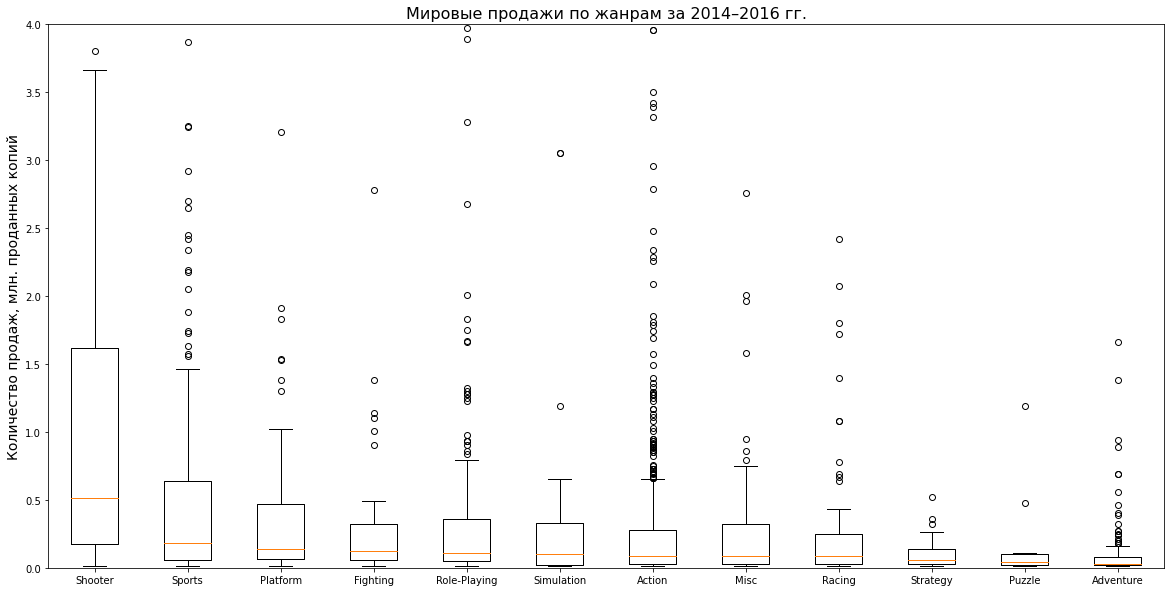

In [85]:
fig = plt.figure(figsize=(20, 10))
box_data = []
labels_for_plots_genres = []

for genre in genres_actual:
    sales_group = data_actual.query(f'genre == "{genre}"')['total_sales']
    box_data.append(sales_group.reset_index(drop=True))  # Сбросить индексы
    labels_for_plots_genres.append(genre)

medians = [group.median() for group in box_data]

# Сортировка по медиане
sorted_data = sorted(zip(medians, box_data, labels_for_plots_genres), 
                     key=lambda x: x[0], 
                     reverse=True) #объединяем объекты и сортируем по медиане
sorted_groups = [x[1] for x in sorted_data]
sorted_labels = [x[2] for x in sorted_data]

plt.boxplot(sorted_groups, labels=sorted_labels)
plt.title('Мировые продажи по жанрам за 2014–2016 гг.', fontsize=16)
plt.ylabel("Количество продаж, млн. проданных копий", fontsize=14)
plt.ylim(0, 4)
plt.show()

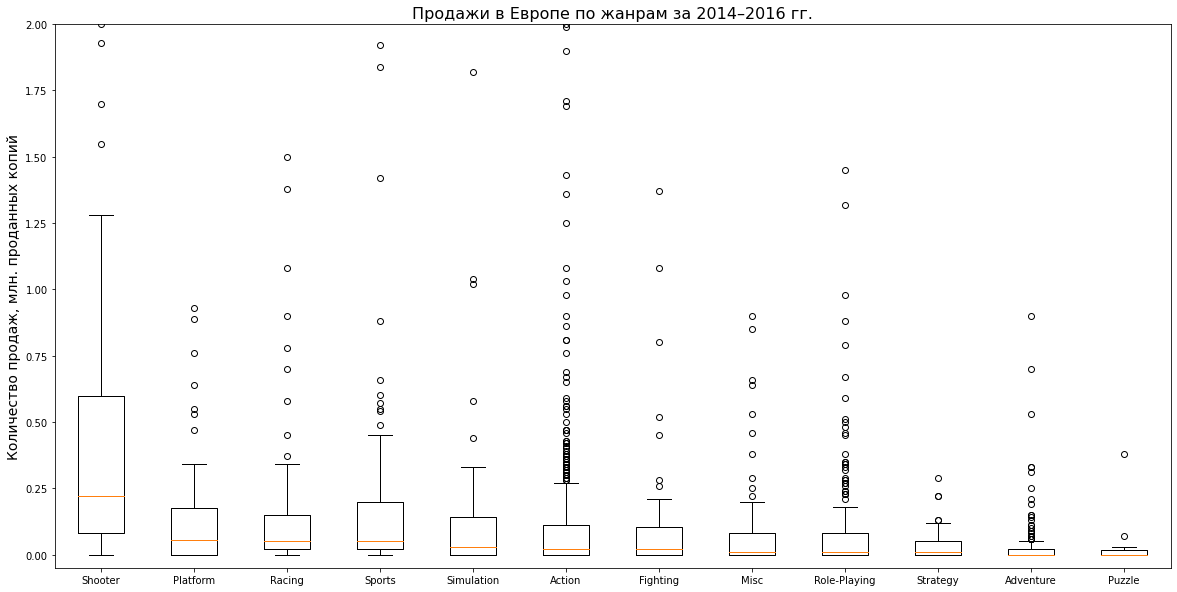

In [86]:
fig = plt.figure(figsize=(20, 10))
box_data = []
labels_for_plots_genres = []

for genre in genres_actual:
    sales_group = data_actual.query(f'genre == "{genre}"')['eu_sales']
    box_data.append(sales_group.reset_index(drop=True))  # Сбросить индексы
    labels_for_plots_genres.append(genre)

medians = [group.median() for group in box_data]

# Сортировка по медиане
sorted_data = sorted(zip(medians, box_data, labels_for_plots_genres), 
                     key=lambda x: x[0], 
                     reverse=True) #объединяем объекты и сортируем по медиане
sorted_groups = [x[1] for x in sorted_data]
sorted_labels = [x[2] for x in sorted_data]

plt.boxplot(sorted_groups, labels=sorted_labels)
plt.title('Продажи в Европе по жанрам за 2014–2016 гг.', fontsize=16)
plt.ylabel("Количество продаж, млн. проданных копий", fontsize=14)
plt.ylim(-0.05, 2)
plt.show()

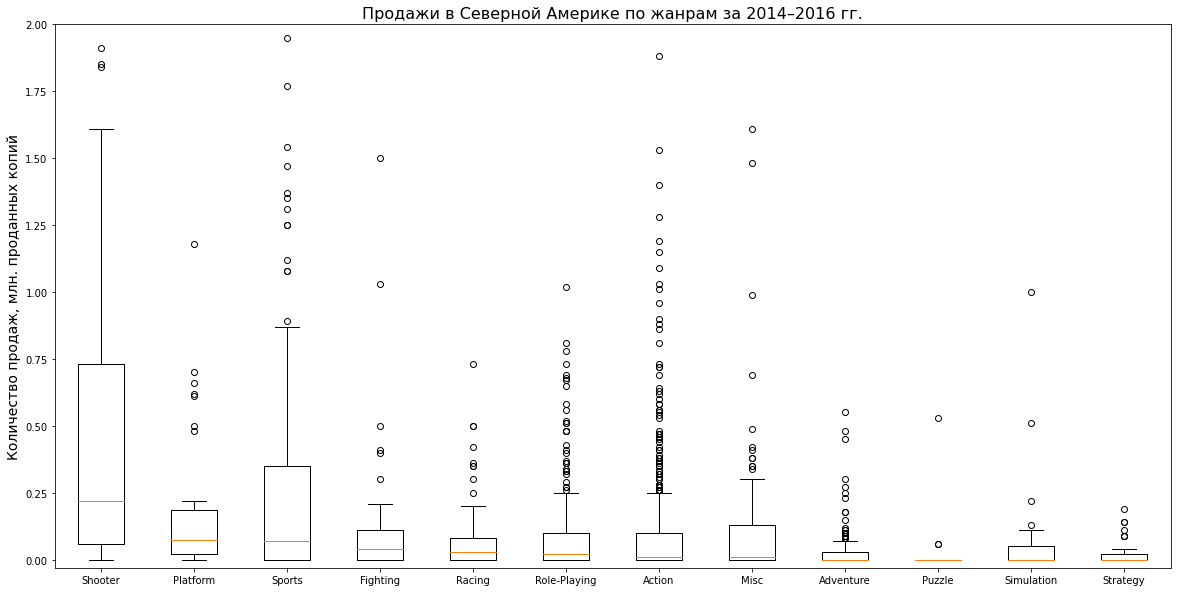

In [87]:
fig = plt.figure(figsize=(20, 10))
box_data = []
labels_for_plots_genres = []

for genre in genres_actual:
    sales_group = data_actual.query(f'genre == "{genre}"')['na_sales']
    box_data.append(sales_group.reset_index(drop=True))  # Сбросить индексы
    labels_for_plots_genres.append(genre)

medians = [group.median() for group in box_data]

# Сортировка по медиане
sorted_data = sorted(zip(medians, box_data, labels_for_plots_genres), 
                     key=lambda x: x[0], 
                     reverse=True) #объединяем объекты и сортируем по медиане
sorted_groups = [x[1] for x in sorted_data]
sorted_labels = [x[2] for x in sorted_data]

plt.boxplot(sorted_groups, labels=sorted_labels)
plt.title('Продажи в Северной Америке по жанрам за 2014–2016 гг.', fontsize=16)
plt.ylabel("Количество продаж, млн. проданных копий", fontsize=14)
plt.ylim(-0.03, 2)
plt.show()

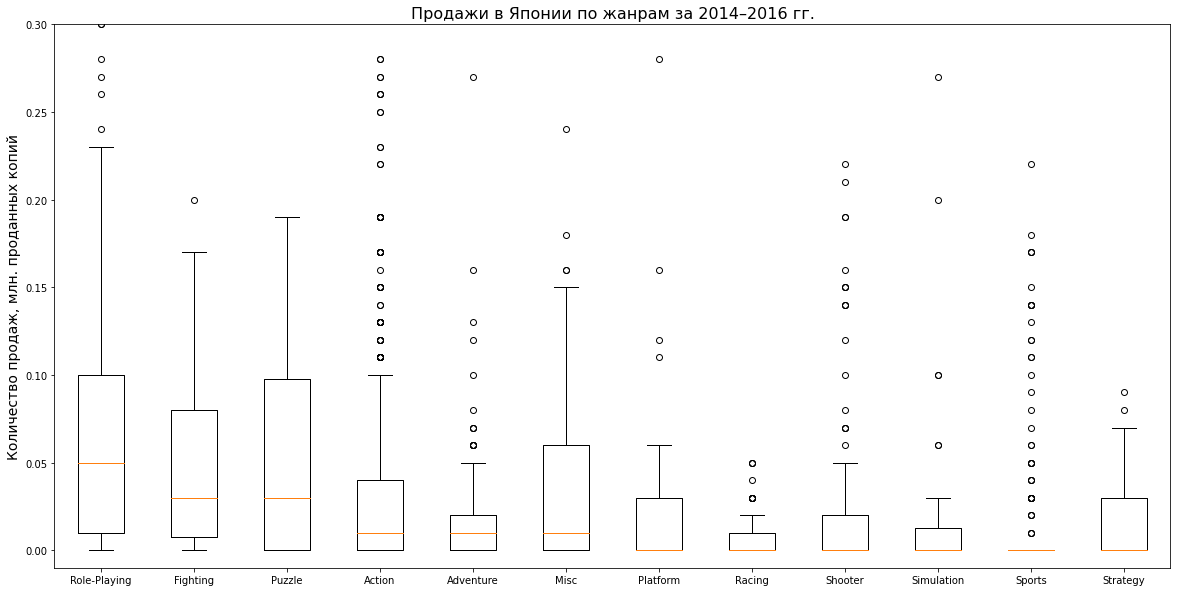

In [88]:
fig = plt.figure(figsize=(20, 10))
box_data = []
labels_for_plots_genres = []

for genre in genres_actual:
    sales_group = data_actual.query(f'genre == "{genre}"')['jp_sales']
    box_data.append(sales_group.reset_index(drop=True))  # Сбросить индексы
    labels_for_plots_genres.append(genre)

medians = [group.median() for group in box_data]

# Сортировка по медиане
sorted_data = sorted(zip(medians, box_data, labels_for_plots_genres), 
                     key=lambda x: x[0], 
                     reverse=True) #объединяем объекты и сортируем по медиане
sorted_groups = [x[1] for x in sorted_data]
sorted_labels = [x[2] for x in sorted_data]

plt.boxplot(sorted_groups, labels=sorted_labels)
plt.title('Продажи в Японии по жанрам за 2014–2016 гг.', fontsize=16)
plt.ylabel("Количество продаж, млн. проданных копий", fontsize=14)
plt.ylim(-0.01, 0.3)
plt.show()

Самым популярным жанром за 2014-2016 годы стал жанр экшенов - 199.36 млн. проданных копий по всему миру. На втором месте - шутеры, на третьем - спортивные игры. Возможно, это связано с тем, что экшен позволяет пользователям проверить свои навыки, так как этот жанр нацелен именно на это. Шутеры, возможно, помогают снять стресс во время игры, а также устроить сетевую игру с друзьями. Спортивные игры - это всегда про болельщиков и их любимые команды (все любители футбола хоть раз играли за Месси в FIFA),  а также соревнования с друзьями.

На японском рынке есть явный перевес в сторону ролевых игр. Возможно, это обусловлено культурой жителей этой страны и их уникальными предпочтениями.

Если смотреть по общемировым продажам, то можно увидеть, что самые большие аномалии в продажах у игр в жанре Shooter. Также у этого жанра самая большая медиана продаж, что говорит о стабильно более высоких продажах по сравнению с другими жанрами. Жанр Action же несмотря на большие суммраные продажи всё же имеет большие продажи из-за аномалий. После шутеров с большим разрывом следует жанр спортивных игр, а уже затем плафторменные игры и файтинги. В Японии же наоброт спортивные игры не очень популярны.

Диаграммы размаха в целом подтверждают выводы из сводной таблицы.

Одно известно точно - мало кто любит игры в пазлы и головоломки, а также стратегии. Это, скорее всего, связано с тем, что такие игры зачастую требуют много времени и очень монотонны. Также очень низкими показателями обладают игры в приключенческом жанре: у них самая маленькая медиана.

**Вывод:** 

- Датасет отражает все основные вехи истории развития компьютерных игр. Расцвет индустрии пришёлся на середину 90-ых годов прошлого века. Именно начиная с этого периода есть смысл рассматривать данные и искать тенденции;
- Самыми крупными платформами за всё время существования игровой индустрии стали PS2, X360, PS3, Wii, DS, PS;
- Средний срок жизни плафтормы - 10-12 лет, пик продаж наблюдается через 3-5 лет от старта продаж, далее, как правило, продажи сходят на нет;
- Наиболее перспективные плафтормы в 2017 году XOne, PS4, DS3 и не стареющие PC;
- Есть слабая корреляция между уровнем продаж и оценкой критиков: чем выше оценки критиков, тем выше продажи;
- Наиболее популярные жанры - экшен, шутеры и спортивные игры, наиболее стабильны в продажах шутеры;
- Наименее популярны стратегии, головоломки и приключенческие игры.

## Составление портретов пользователей

Подготовим таблицы для составления портретов пользователей по регионам

In [89]:
pivot_table_platforms = data_actual.pivot_table(index='platform', 
                                                values=['total_sales', 'na_sales', 'eu_sales', 'jp_sales'], 
                                                aggfunc='sum')
pivot_table_platforms.columns = ['eu_sales_sum', 
                                 'jp_sales_sum', 
                                 'na_sales_sum', 
                                 'total_sales_sum']
for column in pivot_table_platforms.columns:
    pivot_table_platforms[f'{column}_percent'] = round(pivot_table_platforms[f'{column}'] / \
                                                        pivot_table_platforms[f'{column}'].sum() * 100, 2)  
pivot_table_platforms

,eu_sales_sum,jp_sales_sum,na_sales_sum,total_sales_sum,eu_sales_sum_percent,jp_sales_sum_percent,na_sales_sum_percent,total_sales_sum_percent
platform,,,,,,,,
3DS,16.12,44.24,22.64,86.68,5.96,47.52,7.97,11.88
PC,17.97,0.00,7.23,27.05,6.64,0.00,2.55,3.71
PS3,25.54,11.22,22.05,68.18,9.44,12.05,7.76,9.35
PS4,130.04,15.02,98.61,288.15,48.04,16.13,34.71,39.50
PSP,0.00,0.36,0.00,0.36,0.00,0.39,0.00,0.05
PSV,3.53,14.54,2.52,22.40,1.30,15.62,0.89,3.07
Wii,2.59,0.00,2.08,5.07,0.96,0.00,0.73,0.70
WiiU,13.15,7.31,19.36,42.98,4.86,7.85,6.82,5.89
X360,15.49,0.08,28.30,48.22,5.72,0.09,9.96,6.61


In [90]:
pivot_table_genres = data_actual.pivot_table(index='genre', 
                                             values=['total_sales', 'na_sales', 'eu_sales', 'jp_sales'], 
                                             aggfunc='sum')
pivot_table_genres.columns = ['eu_sales_sum', 
                              'jp_sales_sum', 
                              'na_sales_sum', 
                              'total_sales_sum']
for column in pivot_table_genres.columns:
    pivot_table_genres[f'{column}_percent'] = round(pivot_table_genres[f'{column}'] / \
                                                    pivot_table_genres[f'{column}'].sum() * 100,2)  
pivot_table_genres

,eu_sales_sum,jp_sales_sum,na_sales_sum,total_sales_sum,eu_sales_sum_percent,jp_sales_sum_percent,na_sales_sum_percent,total_sales_sum_percent
genre,,,,,,,,
Action,74.68,29.58,72.53,199.36,27.59,31.78,25.53,27.33
Adventure,6.49,3.60,5.64,17.55,2.40,3.87,1.99,2.41
Fighting,6.69,6.37,12.43,28.22,2.47,6.84,4.38,3.87
Misc,12.86,5.61,15.05,37.55,4.75,6.03,5.30,5.15
Platform,6.80,2.69,6.79,18.09,2.51,2.89,2.39,2.48
Puzzle,0.52,0.93,0.65,2.21,0.19,1.00,0.23,0.30
Racing,14.13,1.76,8.74,27.52,5.22,1.89,3.08,3.77
Role-Playing,28.17,31.16,33.47,101.44,10.41,33.47,11.78,13.91
Shooter,65.52,4.87,79.02,170.94,24.21,5.23,27.82,23.43


In [91]:
pivot_table_esrb = data_actual.pivot_table(index='rating', 
                                           values=['total_sales', 'na_sales', 'eu_sales', 'jp_sales'], 
                                           aggfunc='sum')
pivot_table_esrb.columns = ['eu_sales_sum', 
                            'jp_sales_sum', 
                            'na_sales_sum', 
                            'total_sales_sum']
for column in pivot_table_esrb.columns:
    pivot_table_esrb[f'{column}_percent'] = round(pivot_table_esrb[f'{column}'] / \
                                                  pivot_table_esrb[f'{column}'].sum() * 100,2)  
pivot_table_esrb

,eu_sales_sum,jp_sales_sum,na_sales_sum,total_sales_sum,eu_sales_sum_percent,jp_sales_sum_percent,na_sales_sum_percent,total_sales_sum_percent
rating,,,,,,,,
E,58.06,8.94,50.74,133.13,21.45,9.60,17.86,18.25
E10+,26.16,4.46,33.23,71.68,9.66,4.79,11.70,9.83
M,93.44,8.01,96.42,226.54,34.52,8.60,33.94,31.06
RP,58.95,56.90,64.72,198.97,21.78,61.12,22.78,27.28
T,34.07,14.78,38.95,99.13,12.59,15.88,13.71,13.59


### Северная Америка

#### Топ-5 игровых платформ

In [92]:
pivot_table_platforms.sort_values(by='na_sales_sum', ascending=False)[['na_sales_sum', 'na_sales_sum_percent']]

,na_sales_sum,na_sales_sum_percent
platform,,
PS4,98.61,34.71
XOne,81.27,28.61
X360,28.30,9.96
3DS,22.64,7.97
PS3,22.05,7.76
WiiU,19.36,6.82
PC,7.23,2.55
PSV,2.52,0.89
Wii,2.08,0.73


За 2014-2016 года в Северной Америке самыми популярными стали: 
1. PS4 (34.71% от рынка в Северной Америке)
2. XOne (28.61%)
3. X360 (9.96%)
4. 3DS (7.97%)
5. PS3 (7.76%)


Суммарно эти 5 платформ занмают 89% рынка в Северной Америке.

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Портреты клиентов рассчитаны, молодец 
        
Стоит оформить графики раздела TOП-5:
 
+ для каждого ТОП-5 - построить 3 графика рядом с помощью subplots, оптимальнее сравнивать три региона по каждому виду портрета вместе;
+ оформить "двухуровневый заголовок" - и у всех трех графиков вместе, и у каждого из трех по отдельности;
+ при анализе платформ и жанров стоит все, что не вошло в ТОП-5, объединять в категорию "другие" - так картина анализа будет более полной

        
Если столкнешься с трудностью выполнения данного пункта — присылай код, который не получился и вопрос, подумаем вместе
        
https://proproprogs.ru/modules/matplotlib-otobrazhenie-neskolkih-koordinatnyh-osey-v-odnom-okne
        
    

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> пример графиков
        
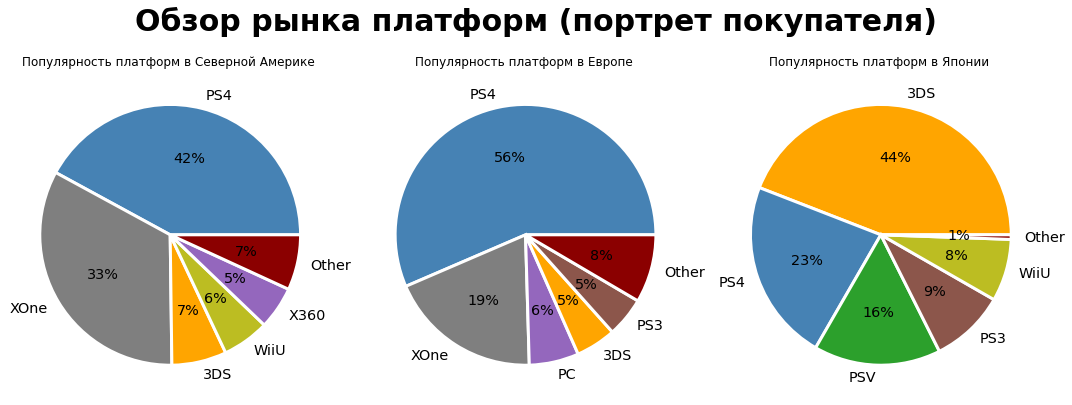        
        

__Если столкнешься с трудностью выполнения данного пункта — присылай код, который не получился и вопрос, подумаем вместе__


#### Топ-5 жанров

In [93]:
pivot_table_genres.sort_values(by='na_sales_sum', ascending=False)[['na_sales_sum', 'na_sales_sum_percent']]

,na_sales_sum,na_sales_sum_percent
genre,,
Shooter,79.02,27.82
Action,72.53,25.53
Sports,46.13,16.24
Role-Playing,33.47,11.78
Misc,15.05,5.30
Fighting,12.43,4.38
Racing,8.74,3.08
Platform,6.79,2.39
Adventure,5.64,1.99


За 2014-2016 года в Северной Америке самыми популярными стали:

1. Shooter (27.82% от рынка в Северной Америке)
2. Action (25.53%)
3. Sports (16.24%)
4. Role-playing (11.78%)
5. Misc(5.30%)


Суммарно эти 5 жанров занмают 86.67% рынка в Северной Америке. Misc - немного перекликается по смыслу с action, так как тоже ориентирован на проверку навыков игрока.

#### Влияние рейтинга

In [94]:
pivot_table_esrb.sort_values(by='na_sales_sum', ascending=False)[['na_sales_sum', 'na_sales_sum_percent']]

,na_sales_sum,na_sales_sum_percent
rating,,
M,96.42,33.94
RP,64.72,22.78
E,50.74,17.86
T,38.95,13.71
E10+,33.23,11.70


Помним, что RP - замена для NaN значений, поэтому их не учитываем.

Чаще всего покупают игры из рейтинга M (mature - взрослые, старше 17 лет) - 33.94%, это в основном игры, содержащие сцены насилия, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику. Реже всего - рейтинг T (teens - подростки). Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

Чаще всего игры покупают взрослые, так как у них есть деньги на это. Интереснее всего играть в реалистичные игры, где как раз будет очень реалистичное игровое пространство.

**Вывод:** Среднестатистический игрок в Северной Америке - это человек старше 17 лет, который предпочитает играть в экшены и шутеры на PS или Xbox. Причем предпочитает новые модели (PS4 и XOne).

### Европа

#### Топ-5 платформ

In [95]:
pivot_table_platforms.sort_values(by='eu_sales_sum', ascending=False)[['eu_sales_sum', 'eu_sales_sum_percent']]

,eu_sales_sum,eu_sales_sum_percent
platform,,
PS4,130.04,48.04
XOne,46.25,17.09
PS3,25.54,9.44
PC,17.97,6.64
3DS,16.12,5.96
X360,15.49,5.72
WiiU,13.15,4.86
PSV,3.53,1.30
Wii,2.59,0.96


За 2014-2016 года в Европе самыми популярными стали: 
1. PS4 (48.04% от количества продаж в Европе)
2. XOne (17.09%)
3. PS3 (9.44%)
4. PC (6.64%)
5. 3DS (5.96%)

Суммарно эти 5 платформ занмают 87.17% рынка в Европе.

#### Топ-5 жанров

In [96]:
pivot_table_genres.sort_values(by='eu_sales_sum', ascending=False)[['eu_sales_sum', 'eu_sales_sum_percent']]

,eu_sales_sum,eu_sales_sum_percent
genre,,
Action,74.68,27.59
Shooter,65.52,24.21
Sports,45.73,16.89
Role-Playing,28.17,10.41
Racing,14.13,5.22
Misc,12.86,4.75
Simulation,7.30,2.70
Platform,6.80,2.51
Fighting,6.69,2.47


За 2014-2016 года в Европе самыми популярными стали: 
1. Action (27.59% от количества продаж в Европе)
2. Shooter (24.21%)
3. Sports (16.89%)
4. Role-Playing (10.41%)
5. Racing (5.22%)

Суммарно эти 5 жанров занмают 84.32% рынка в Европе.

#### Влияние рейтинга

In [97]:
pivot_table_esrb.sort_values(by='eu_sales_sum', ascending=False)[['eu_sales_sum', 'eu_sales_sum_percent']]

,eu_sales_sum,eu_sales_sum_percent
rating,,
M,93.44,34.52
RP,58.95,21.78
E,58.06,21.45
T,34.07,12.59
E10+,26.16,9.66


Распределение по рейтингам в Европе очень схоже с Северной Америкой

**Вывод:** среднестатистчиеский игрок в Европе - человек от 17 лет, который играет в шутеры и экшены на PS, в меньшей степени на Xbox. Причём половина продаж пришлась на PS4.

Важно отметить, что по сравнению с Северной Америкой в Европе отдают больше предпочтению Sony (57.48% и 42.47%), нежели Xbox (17.09% и 38.57%). Также в Европе больше предпочитают гонки, нежели Misc, хотя различия слишком малы между этими двумя жанрами в Европе.

### Япония

#### Топ-5 платформ

In [98]:
pivot_table_platforms.sort_values(by='jp_sales_sum', ascending=False)[['jp_sales_sum', 'jp_sales_sum_percent']]

,jp_sales_sum,jp_sales_sum_percent
platform,,
3DS,44.24,47.52
PS4,15.02,16.13
PSV,14.54,15.62
PS3,11.22,12.05
WiiU,7.31,7.85
PSP,0.36,0.39
XOne,0.32,0.34
X360,0.08,0.09
PC,0.00,0.00


За 2014-2016 года в Японии самыми популярными стали:

1. 3DS	(47.52%)
2. PS4	(16.13%)
3. PSV	(15.62%)
4. PS3	(12.05%)
5. WiiU (7.85%)

Суммарно эти 5 платформ занмают 99.17% рынка в Японии. Причем почти половина продаж приходится на 3DS.

#### Топ-5 жанров

In [99]:
pivot_table_genres.sort_values(by='jp_sales_sum', ascending=False)[['jp_sales_sum', 'jp_sales_sum_percent']]

,jp_sales_sum,jp_sales_sum_percent
genre,,
Role-Playing,31.16,33.47
Action,29.58,31.78
Fighting,6.37,6.84
Misc,5.61,6.03
Shooter,4.87,5.23
Adventure,3.60,3.87
Sports,3.26,3.50
Platform,2.69,2.89
Simulation,2.31,2.48


За 2014-2016 года в Японии самыми популярными стали:

1. Role-Playing (33.47%)
2. Action	(31.78%)
3. Fighting (6.84%)
4. Misc	(6.03%)
5. Shooter	(5.23%)

Суммарно эти 5 жанров занмают 83.44% рынка в Японии.

#### Влияние рейтинга

In [100]:
pivot_table_esrb.sort_values(by='jp_sales_sum', ascending=False)[['jp_sales_sum', 'jp_sales_sum_percent']]

,jp_sales_sum,jp_sales_sum_percent
rating,,
RP,56.90,61.12
T,14.78,15.88
E,8.94,9.60
M,8.01,8.60
E10+,4.46,4.79


Тут больше всего игр с пропусками, что говорит о том, что японцы в меньшей степени обращают внимание на возрастные рейтинги ESRB, так как этот рейтинг используется в США и Канаде. В Японии же, скорее всего, будут ориентироваться на региональные рейтинги.
Наиболее популярны игры с возрастным рейтингом T (Teens - подростки).

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Заполнение пропусков в рейтинге позволило определить отличия региональных рынков 
        
        Тут больше всего игр с пропусками, что говорит о том, что японцы в меньшей степени обращают внимание на возрастные рейтинги.
        
В начале проекта была более практичная идея о том, что в Японии устанавливает свои правила CERO и основная причина пропусков связана именно с отличием регионального рынка от мирового       

**Вывод:** среднестатистический пользователь в Японии играет в ролевые игры, экшены, файтинги и шутеры на Nintendo 3DS и PS.

Это достаточно сильно отличается от результатов по Северной Америке и Европе.

Подведём итоги и составим сводные графики по портретам пользователей.

In [101]:
#функция, выделяющая топ-5 по признаку, а остальные группирующая в категорию other
def make_top5(region, feature):
    pv_tab = data_actual.pivot_table(index=feature, values=region+'_sales', aggfunc='sum').reset_index(drop=False)
    pv_tab.columns = [feature, 'sales_sum']
    pv_tab = pv_tab.sort_values(by='sales_sum', ascending=False)
    top = pv_tab.head()
    other = pv_tab['sales_sum'][5:].sum()
    other_row = pd.DataFrame({feature: ['others'], 'sales_sum': [other]})
    final = pd.concat([top, other_row], ignore_index=True)
    return final
    
    

In [102]:
make_top5('na', 'platform')

,platform,sales_sum
0,PS4,98.61
1,XOne,81.27
2,X360,28.30
3,3DS,22.64
4,PS3,22.05
5,others,31.19


Функция работает. Можно использовать её дальше

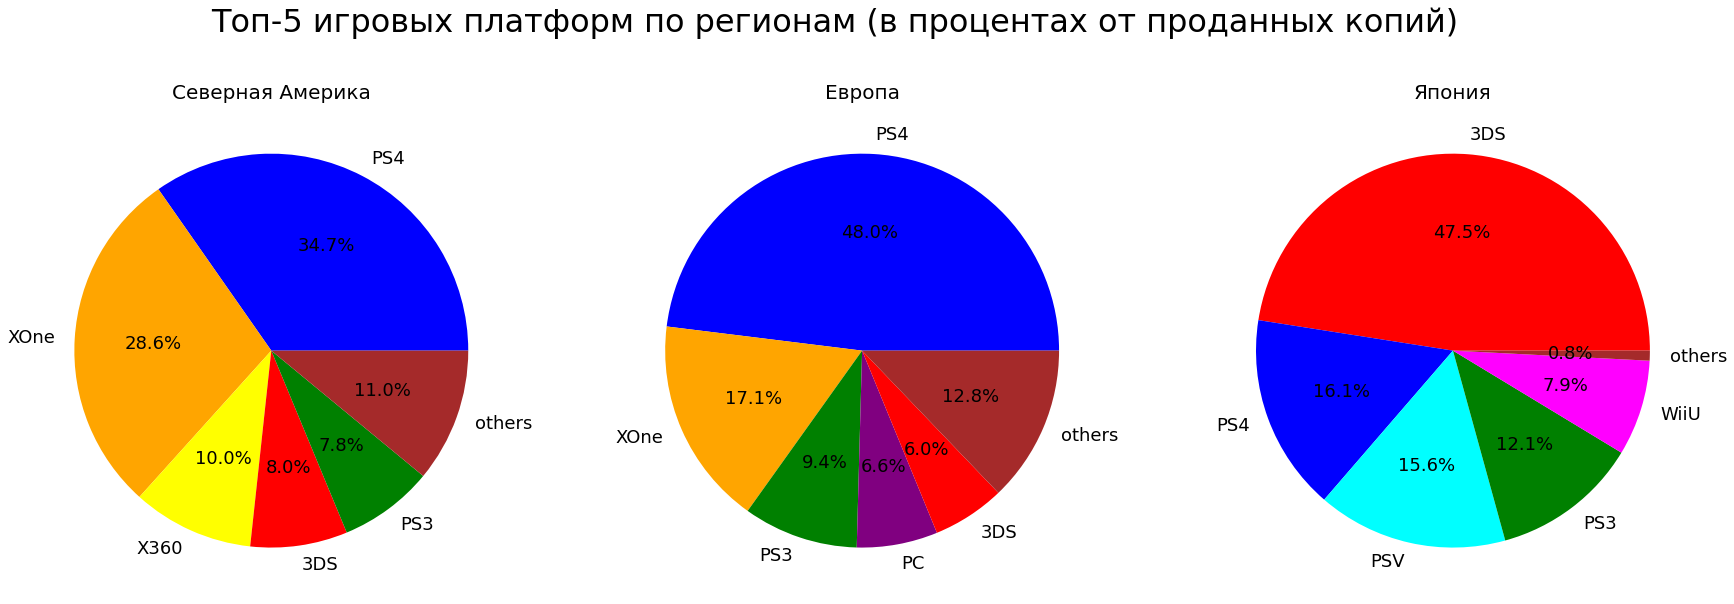

In [103]:
data_na = make_top5('na', 'platform')
data_eu = make_top5('eu', 'platform')
data_jp = make_top5('jp', 'platform')

# Настройки шрифта
font_properties = {
    'family': 'DejaVu Sans',  # Шрифт
    'size': 18,         # Размер
    'weight': 'normal',   # Жирность 
    'color': 'black'    # Цвет
}

category_colors = {
    'PS4': 'blue',     # Синий
    'PS3': 'green',      # Зелёный
    'XOne': 'orange',  # Оранжевый
    '3DS': 'red',    # Красный
    'WiiU': 'magenta',    # Розовый
    'PC': 'purple',      # Красный
    'others': 'brown',  # Фиолетовый
    'X360': 'yellow',    #Жёлтый
    'PSV': 'cyan'        # Голубой
}


f, ax = plt.subplots(1, 3)

#подпись общего графика, установкаразмера окна
f.suptitle('Топ-5 игровых платформ по регионам (в процентах от проданных копий)', fontsize=32)
f.set_size_inches(30, 10)

#подпись каждого subplot
ax[0].set_title('Северная Америка', fontsize=20)
ax[1].set_title('Европа', fontsize=20)
ax[2].set_title('Япония', fontsize=20)

ax[0].pie(data_na['sales_sum'], 
          labels=data_na['platform'], 
          autopct='%1.1f%%',
          textprops=font_properties,
         colors = [category_colors[cat] for cat in data_na['platform']])
ax[1].pie(data_eu['sales_sum'],
         labels=data_eu['platform'], 
          autopct='%1.1f%%',
          textprops=font_properties,
         colors=[category_colors[cat] for cat in data_eu['platform']])
ax[2].pie(data_jp['sales_sum'],
         labels=data_jp['platform'], 
          autopct='%1.1f%%',
          textprops=font_properties,
         colors=[category_colors[cat] for cat in data_jp['platform']])

plt.show()

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Отлично, молодец

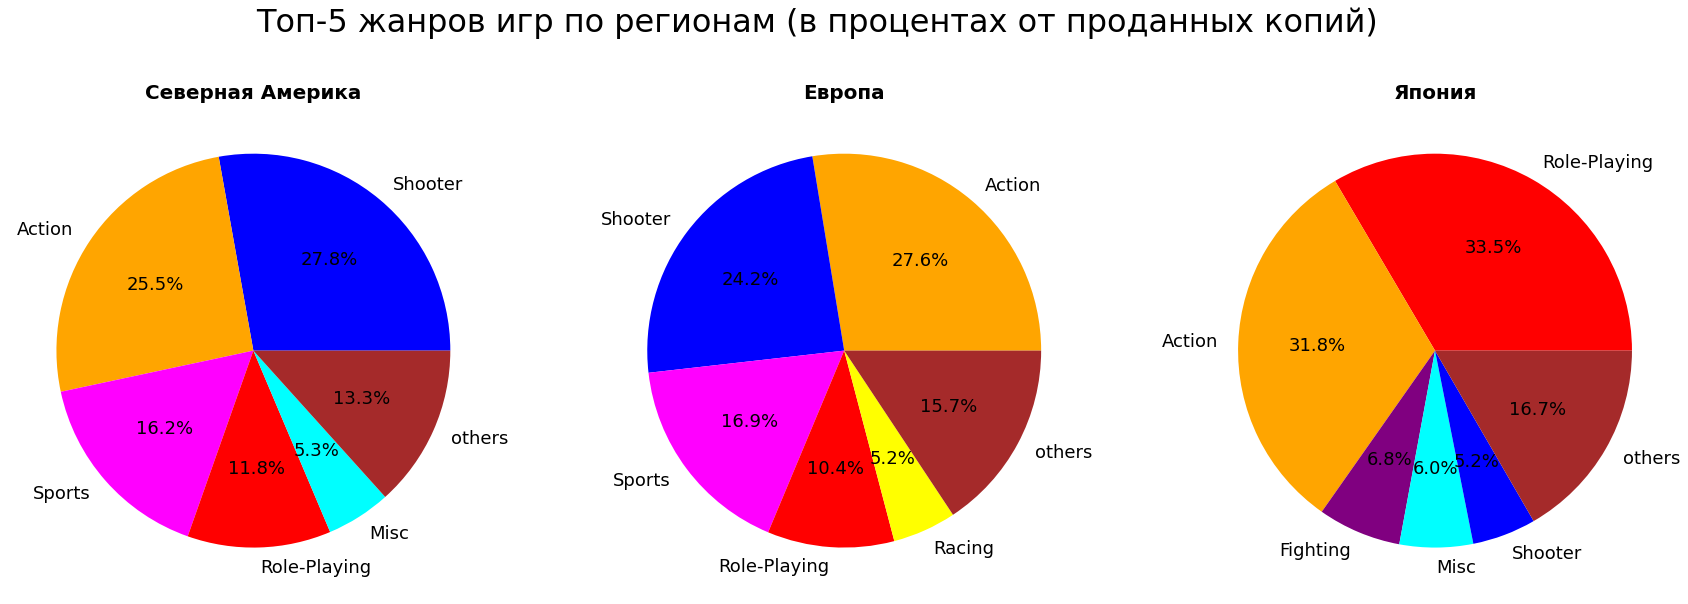

In [104]:
data_na = make_top5('na', 'genre')
data_eu = make_top5('eu', 'genre')
data_jp = make_top5('jp', 'genre')

# Настройки шрифта
font_properties = {
    'family': 'DejaVu Sans',  # Шрифт
    'size': 18,         # Размер
    'weight': 'normal',   # Жирность 
    'color': 'black'    # Цвет
}

category_colors = {
    'Shooter': 'blue',     # Синий
    'Action': 'orange',  # Оранжевый
    'Role-Playing': 'red',    # Красный
    'Sports': 'magenta',    # Пурпурный
    'Fighting': 'purple',      # Красный
    'others': 'brown',  # Фиолетовый
    'Racing': 'yellow',    #Жёлтый
    'Misc': 'cyan'        # Голубой
}


f, ax = plt.subplots(1, 3)

#подпись общего графика, установкаразмера окна
f.suptitle('Топ-5 жанров игр по регионам (в процентах от проданных копий)', fontsize=32)
f.set_size_inches(30, 10)

#подпись каждого subplot
ax[0].set_title('Северная Америка', fontsize=20, fontweight='bold')
ax[1].set_title('Европа', fontsize=20, fontweight='bold')
ax[2].set_title('Япония', fontsize=20, fontweight='bold')

ax[0].pie(data_na['sales_sum'], 
          labels=data_na['genre'], 
          autopct='%1.1f%%',
          textprops=font_properties,
         colors = [category_colors[cat] for cat in data_na['genre']])
ax[1].pie(data_eu['sales_sum'],
         labels=data_eu['genre'], 
          autopct='%1.1f%%',
          textprops=font_properties,
         colors = [category_colors[cat] for cat in data_eu['genre']])
ax[2].pie(data_jp['sales_sum'],
         labels=data_jp['genre'], 
          autopct='%1.1f%%',
          textprops=font_properties,
         colors = [category_colors[cat] for cat in data_jp['genre']])

plt.show()

**Общий вывод:**
- Среднестатистический игрок в Северной Америке - это человек старше 17 лет, который предпочитает играть в экшены и шутеры на PS или Xbox. Причем предпочитает новые модели (PS4 и XOne).
- Среднестатистчиеский игрок в Европе - человек от 17 лет, который играет в шутеры и экшены на PS, в меньшей степени на Xbox.
- Среднестатистический пользователь в Японии играет в ролевые игры, экшены, файтинги и шутеры на Nintendo 3DS и PS.

При этом важно отметить, что японцы меньше ориентированы на рейтинг ESRB, хотя в Европе и Северной Америке чаще всего покупают игры с рейтингом M. Также в Европе и Северной Америке очень схожие предпочтения по приставкам и жанрам, тогда как в Японии этот состав принципиально другой. Если ориентироваться на японский рынок, то необходимо проводить более детальные исследования.

## Проверка гипотез

Зададимся уровнем статистической значимости 1%

In [105]:
alpha = 0.01

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Необходимо сравнить среднее значение выручек двух выборок: пользовательские рейтинги у Xbox One и PC. Воспользуемся функцией *ttest_ind*, так как выборки независимые. Воспользуемся двухсторонней альтернативной гипотезой.

Выдвинем гипотезы.  
$H_0:$ Средние пользовательские рейтинги платформ Xbox One и PC равны  
$H_1:$ Средние пользовательские рейтинги платформ Xbox One и PC не равны

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Гипотезы сформулированы верно

Необходимо учесть, что пропущенные значения были заменены в этом столбце нулями, поэтому от них необходимо избавиться при анализе гипотез.

In [106]:
xbox_user_score = data_actual.query('~(user_score == 0) and platform == "XOne"')['user_score']
pc_user_score = data_actual.query('~(user_score == 0) and platform == "PC"')['user_score']

print('Средний пользовательский рейтинг платформы Xbox One: ', xbox_user_score.mean())
print('Среднее значение ежемесячного дохода от пользователей без подписки: ', pc_user_score.mean())

results = st.ttest_ind(xbox_user_score, pc_user_score)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Средний пользовательский рейтинг платформы Xbox One:  6.594545454545456
Среднее значение ежемесячного дохода от пользователей без подписки:  6.298360655737705
p-значение:  0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Важно удалить пропуски и «заглушки» перед проведением теста, молодец

Нулевая гипотеза не отвергается, то есть можно предположить, что пользователи Xbox One и пользователи компьютеров оценивают игры примерно одинаково.

В целом стоит понимать, что p-value = 0.14 - это вероятность получить такие же или более выраженные различия, при условии, что нулевая гипотеза верна. То есть мы полагаем, что средние оценок пользователей Xbox Xone и PS4 равны, тогда такое различие в выборочных средних (и более выраженное) может произойти с вероятностью 0.14.

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Что означает на языке статистики p-значение: 0.14012658403611647

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера в2</b></font>
<br /> 
<font size="3", color = "black">
<br />
Приведу пример и теорию для понимания формулировок и интерпретации итогов проведения гипотез</b>
        
      
Задача. Приведены два датасета: сумма покупок, совершённых за месяц посетителями, привлечёнными по двум разным каналам. В вашем распоряжении случайная выборка из 30 покупок для каждого канала.
        
H0 - средние чеки равны
        
        
H1 - средние чеки НЕ равны

Да сама формулировка нулевой и альтернативной гипотезы звучит именно так, но результат теста интерпретируется другими словами
    
        
Формулирование двусторонних гипотез. <br>
        
<b>Никакие экспериментально полученные данные никогда не подтвердят какую-либо гипотезу. Это наше фундаментальное ограничение. </b>Данные могут лишь не противоречить ей или, наоборот, показывать крайне маловероятные результаты (при условии, что гипотеза верна). Но и в том, и в другом случае нет оснований утверждать, что выдвинутая гипотеза доказана.
Допустим, данные гипотезе не противоречат, тогда мы её не отвергаем. Если же мы приходим к выводу, что получить такие данные в рамках этой гипотезы вряд ли возможно, у нас появляется основание отбросить эту гипотезу.
     

In [107]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера в2</b></font>
<br /> 
<font size="3", color = "black">
<br />
Интерпретация результата:

Полученное значение p-value говорит о том, что хотя средний чек пришедших из разных каналов и неодинаков, <b>с вероятностью в почти 19% такое или большее различие можно получить случайно. </b>Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними чеками.
        
А если p-value  будет равно 0,9999, то это значит, что с вероятностью почти 100% <u>такое различие</u> можно получить случайно — то есть почти никогда :)  (но учитываем, что тест проводится на выборке из генеральной совокупности, все может поменяться)


### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

В этом случае нам снова потребуется *ttest_ind*, так как необходимо сравнить две независимые выборки. Выдвигать будем двустороннюю альтернативную гипотезу.

Выдвинем гипотезы.  
$H_0:$ Средние пользовательские рейтинги жанров Action и Sports равны  
$H_1:$ Средние пользовательские рейтинги жанров Action и Sports не равны

In [108]:
action_user_score = data_actual.query('~(user_score == 0) and genre == "Action"')['user_score']
sports_user_score = data_actual.query('~(user_score == 0) and genre == "Sports"')['user_score']

print('Средний пользовательский рейтинг жанра Action: ', action_user_score.mean())
print('Средний пользовательский рейтинг жанра Sports: ', sports_user_score.mean())

results = st.ttest_ind(action_user_score, sports_user_score)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Средний пользовательский рейтинг жанра Action:  6.760606060606061
Средний пользовательский рейтинг жанра Sports:  5.2251968503937
p-значение:  2.8711147985105864e-19
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергается, есть основания не отвергать альтернативную. То есть стоит полагать, что средние пользовательские рейтинги у этих жанров не равны.

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Стоит исправить все подобные моменты
        
         принимаем альтернативную 
 
        
Формулирование двусторонних гипотез. <br>
        
<b>Никакие экспериментально полученные данные никогда не подтвердят какую-либо гипотезу. Это наше фундаментальное ограничение. </b>Данные могут лишь не противоречить ей или, наоборот, показывать крайне маловероятные результаты (при условии, что гипотеза верна). Но и в том, и в другом случае нет оснований утверждать, что выдвинутая гипотеза доказана.
Допустим, данные гипотезе не противоречат, тогда мы её не отвергаем. Если же мы приходим к выводу, что получить такие данные в рамках этой гипотезы вряд ли возможно, у нас появляется основание отбросить эту гипотезу.
        
https://allatambov.github.io/psms/pdf/hypo-test.pdf


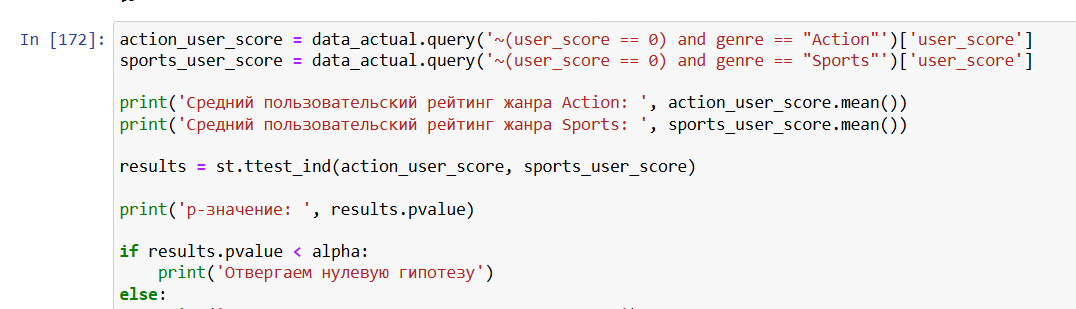

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера </b></font>
<br /> 
<font size="3", color = "black">
<br />   Кажется, весь код на проекте запускался вручную ... 172-я строка кода на проекте у которого всего 81 ячейка
    
    
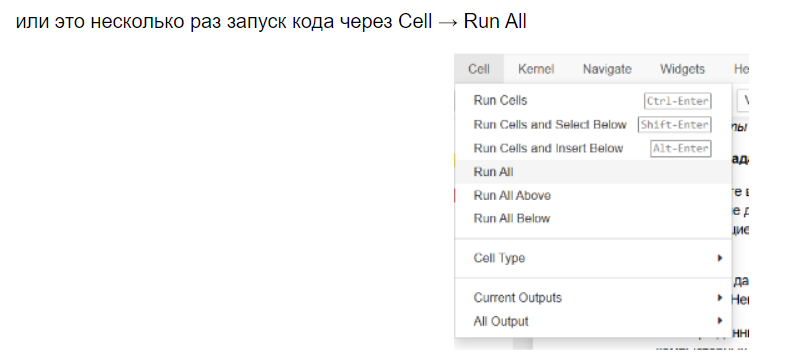    
    
   
    
Проверить работоспособность кода — можно нажав на панели Jupiter Hub Kernel и Restart & Run All (см скриншот ниже).

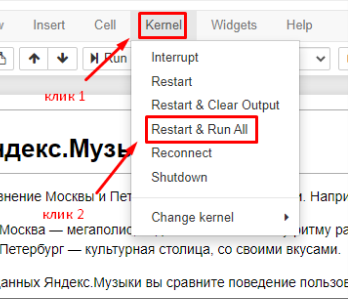

# Общий вывод

В ходе работы был проанализирован датасет продаж компьютерны игр онлайн-магазина "Стримчик".  
Были выполнены в процессе предобработки: 
* Выгрузка данных;
* Поиск пропущенных значений и их заполнение;
* Изменён тип данных в столбцах;
* Поиск дубликатов;
* Добавление нового столбца с суммарными продажами по миру.


В ходе исследовательского анализа было выявлено:
* Датасет отражает все основные вехи истории развития компьютерных игр. Расцвет индустрии пришёлся на середину 90-ых годов прошлого века, поэтому в рассмотрение был взят период с 1995 года;
* Самыми крупными платформами за всё время существования игровой индустрии стали PS2, X360, PS3, Wii, DS, PS;
* Средний срок жизни плафтормы - 10-12 лет, пик продаж наблюдается через 3-5 от старта продаж, далее, как правило, продажи сходят на нет;
* На основе среднего срока жизни платформы был взят актулаьный период для исследования - с 2014 по 2016 года;
* Наиболее перспективные плафтормы в 2017 году XOne и PS4, а также 3DS и PC;
* Есть слабая корреляция между уровнем продаж и оценкой критиков: чем выше оценки критиков, тем выше продажи;
* Наиболее популярные жанры - экшен, шутеры и спортивные игры, наиболее стабильны в продажах шутеры;
* Наименее популярны стратегии, головоломки и приключенческие игры.

Были составлены портреты пользователей по регионам: 
- Среднестатистический игрок в Северной Америке - это человек старше 17 лет, который предпочитает играть в экшены и шутеры на PS или Xbox. Причем предпочитает новые модели (PS4 и XOne).
- Среднестатистчиеский игрок в Европе - человек от 17 лет, который играет в шутеры и экшены на PS, в меньшей степени на Xbox.
- Среднестатистический пользователь в Японии играет в ролевые игры, экшены, файтинги и шутеры на Nintendo 3DS и PS.

Также было выявлено, что рейтинг ESRB мало интересен японскому сегменту рынка, так как у них есть региональные рейтинги. В целом японский сегмент сильно отличается от европейского и американского.

С помощью статистического анализа были проверены гипотезы и сделаны следующие выводы (уровень статистической значимости 1%):
* Пользователи Xbox One и PC в среднем одинаково лояльны к играм;
* Средние пользовательские рейтинги у жанров Action и Sports не равны, то есть пользвоатели отдают предпочтение какому-то из жанров.

Рекомендации: 
* Сосредоточить продажи в Европе и Северной Америке на Sony PS4 и Xbox One;
* Продажи игр в Японии лучше проводить с упором на Nintendo 3DS;
* Если сосредоточить продажи игр на PS, Xbox и Nintendo, то можно покрыть более 80% рынка;
* Увеличить ассортимент игр в жанрах action, shooter, misc, role-playing, race, так как эти жанры наиболее популярны. Наиболее стабильные продажи у игр в жанре Shooter;
* При исследовании региональных рынков делать упор на региональные рейтинги и оценочные ресурсы.

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Отличный вывод, наполненный инсайтами, сравнениями, определениями ключевых особенностей рынка
         

<div class="alert alert-success">
<font size="5", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />   
Ты выполнил практически все пункты проекта, молодец! Проведен значительный объем исследования 
        
Критические ❌ комментарии связаны с неточностями: 

 + выполнить проверку на дублирование записей
 + дополнить перечень перспективных платформ
 + исправить выборки в исследовании зависимости по платформам конкурентам (от оценок критиков и пользователей)        
 + оценить прибыльность жанров на диаграмме размаха
 + построить графики в ТОП-5 
 + в разделе проверки гипотез можно более подробно расшифровать значение p_value 
 + перепроверить промежуточные и итоговый выводы после всех исправлений

Стоит обратить внимание на ⚠️ комментарии...        
        
Если будут вопросы про мои комментарии - задавай, если какой-то формат взаимодействия не устраивает или есть какие-то другие пожелания - пиши :)

<div class="alert alert-success">
    <font size="5", color= "seagreen"><b>Жду твой проект и твои комментарии 🤝</b></font><br />

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
<br /> 
<font size="3", color = "black">
<br />
Может пригодиться  
    
   
[Визуализация](https://dfedorov.spb.ru/pandas/%D0%AD%D1%84%D1%84%D0%B5%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D0%B5%20%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20Matplotlib.html)


[Искусство статистики](https://www.mann-ivanov-ferber.ru/books/iskusstvo-statistiki/)
        
[Постер «Графики, которые убеждают всех»](https://disk.yandex.ru/i/JddXjpYx7YtK0Q)  
        
        
В помощь — как реализовать интерактивный план проекта вручную (для собственных проектов), смотри по <a href="https://stackoverflow.com/questions/49535664/how-to-hyperlink-in-a-jupyter-notebook/49717704">ссылке</a>
    
пара ссылок и по разделам проекта можно будет переходить без пролистывания всего кода, особенно актуально на проектах длина которых >  10 страниц (и там где не установлен плагин TOC)   
    
Плюс    
    
[Цепочка методов в pandas](https://habr.com/ru/articles/722170/)    
    
[Подборка статей о работе с библиотеками для анализа данных на языке Python](https://dfedorov.spb.ru/pandas/)    

## Бонус

In [109]:
import numpy as np

In [110]:
data_games = pd.read_csv('/datasets/games.csv')

In [111]:
data_games.columns = map(str.lower, data_games.columns)

In [112]:
data_games = data_games.dropna(subset = ['year_of_release', 'name', 'genre'])

In [113]:
data_games['user_score'] = data_games['user_score'].replace('tbd', np.nan).astype('float')

In [114]:
data_games['rating'] = data_games['rating'].fillna('unknown')

In [115]:
data_games['total_sales'] = data_games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [116]:
# check
# круги + категория другие

# функция не работает на версии библиотеки pandas >= 2.0 (метод .append устарел)

def graph (df, year, region, name, axes):
    
# фильтруем выборку по переменной

    df = df.query('year_of_release >= @year')

# собираем ТОП-5

# считаем сумму продаж

    sales_max = df.pivot_table(index='platform', 
                           values=region, 
                           aggfunc='sum').sum()    

# создаем ТОП-5

    sales = df.pivot_table(index='platform', 
                           values=region, 
                           aggfunc='sum').nlargest(5, region)

# считаем сумму продаж остальных категорий

    sales_other =  sales_max -  sales.sum()

# добавляем 6-ю категорию в ТОП-5        
    sales = sales.reset_index()
    sales.loc[5] = ['Other', sales_other[0]]

    
# добавляем 6-ю категорию в ТОП-5 старым методом

#     sales = (
#             sales.append({'platform': 'Other', region: df[region].sum() 
#                        - sales[region].sum()}, ignore_index= True)
#          )

    
# меняем названия колонок, но неоптимальным способом 🤝

    sales.columns = ['platform', 'sales']

# создаем словарь цветов    
# Цветовая гамма не подбиралась специально под платформы, кому-что попадется, 😉 
      
    labels_c=sales.platform
    colours = {'Wii':'C60', 'NES':'C1', 'GB':'C2', 'DS':'C3', 'X360':'C4', 
    'PS3':'C5', 'PS2':'C6', 'SNES':'C7', 'GBA':'C8',
               'PS4':'lightsteelblue', '3DS':'orange', 
               'N64':'C11', 'PS':'C12', 'XB':'C13', 'PC':'Fuchsia', '2600':'C15', 'PSP':'C48', 
               'XOne':'LimeGreen',
               'WiiU':'C18', 'GC':'C19', 'GEN':'C20', 'DC':'C21', 'PSV':'C22', 
               'SAT':'C23', 'SCD':'C24', 'WS':'C25', 'NG':'C26', 
               'TG16':'C27', '3DO':'C28', 'GG':'C29', 'PCFX':'C30', 'Other':'darkred'}
   
# рисуем графики

    sales.plot(kind='pie',
               y="sales",
               
               autopct='%1.0f%%',
               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
               textprops={'size': 'x-large'}, 
               labels= labels_c,
               colors=[colours[key] for key in labels_c],
               legend=False, 
               title = f"Популярность платформ в {name} ", 
               ax = axes).set(ylabel='')
    
# устанавливаем границы для графиков, чтобы не перекрывали друг друга
    
    plt.tight_layout()

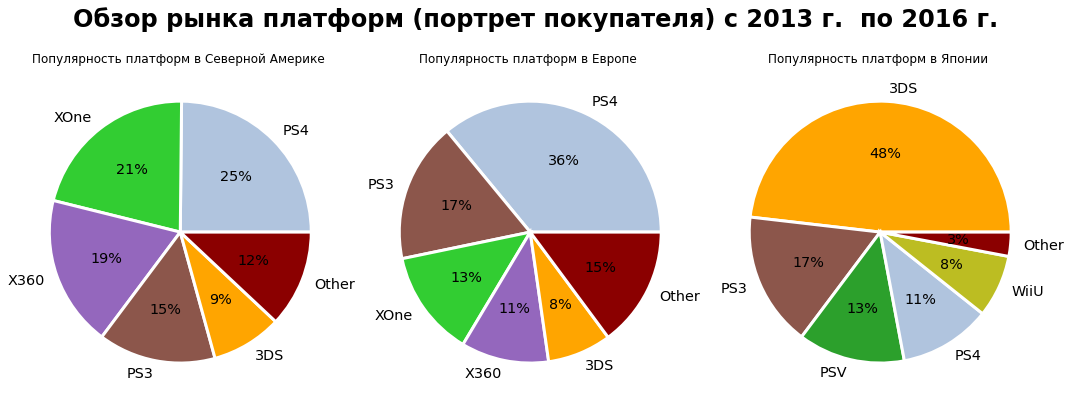

In [117]:
# check
# круги в ряд

x_year = 2013

fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle(f'Обзор рынка платформ (портрет покупателя) с {x_year} г.  по 2016 г.', fontsize = 24, fontweight='bold')

graph(data_games, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(data_games, x_year,'eu_sales', 'Европе', axes[1])
graph(data_games, x_year, 'jp_sales', 'Японии', axes[2])

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Оптимальный период для исследования 2014-2016 гг., т.к. данные за 2016 г. неполные

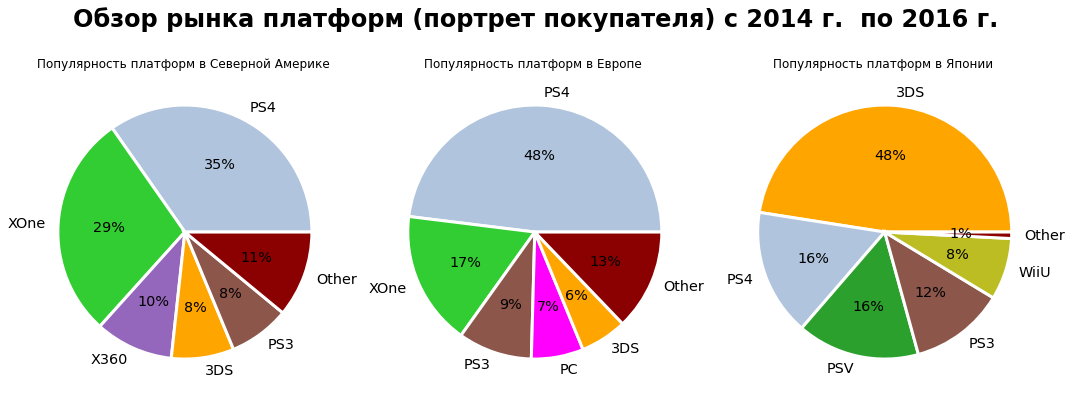

In [118]:
# check
# круги в ряд

x_year = 2014

fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle(f'Обзор рынка платформ (портрет покупателя) с {x_year} г.  по 2016 г.', fontsize = 24, fontweight='bold')

graph(data_games, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(data_games, x_year,'eu_sales', 'Европе', axes[1])
graph(data_games, x_year, 'jp_sales', 'Японии', axes[2])

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 2015 год взят для акцентирования на изменении доли в продажах современных платформ

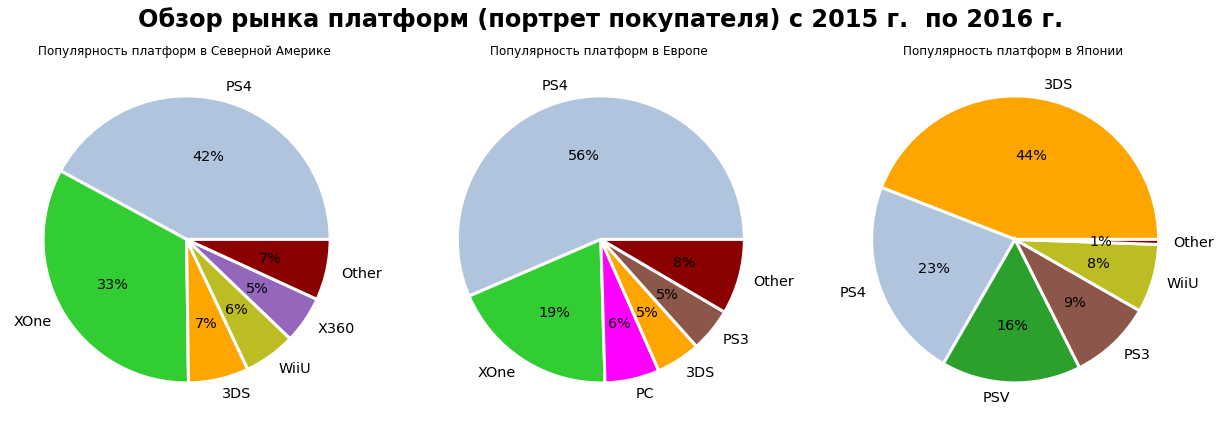

In [119]:
# check
# круги в ряд

x_year = 2015

fig, axes = plt.subplots(1, 3, figsize = (18,6))
fig.suptitle(f'Обзор рынка платформ (портрет покупателя) с {x_year} г.  по 2016 г.', fontsize = 24, fontweight='bold')

graph(data_games, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(data_games, x_year,'eu_sales', 'Европе', axes[1])
graph(data_games, x_year, 'jp_sales', 'Японии', axes[2])

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Стоит обратить внимание на словарь цветов, когда на любом графике каждая платформа имеет свой цвет

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Я выбрал неудачный цвет для категории — «Другие», на темном фоне не видно цифры 😉

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Я недоработал алгоритм расчета ТОП 5+1, например в последнем примере в бонусной части у Японии сумма процентов составляет 101%, что не совсем корректно. И здесь желательно усложнить алгоритм расчетов (при создании выборки), чтобы избегать таких расхождений 